In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
path = "f_9.png"

In [3]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [13]:
def get_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

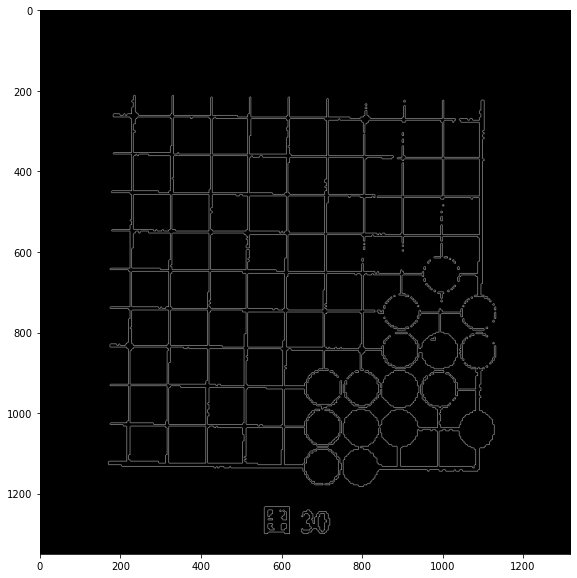

In [14]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
edges = get_edges(img_gray)
plt.imshow(to_RGB(edges))
plt.show() 

In [15]:
def all_lines(img_gray, hough_threshold):
        HOUGH_RHO = 1
        HOUGH_THETA = np.pi / 180

        edges = get_edges(img_gray)
        size = min(img_gray.shape[0:2])
        lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=hough_threshold,
                                minLineLength=size/2, maxLineGap=size)  ### ?
        if lines is None:
            return None
        return np.reshape(lines, (lines.shape[0], lines.shape[2]))

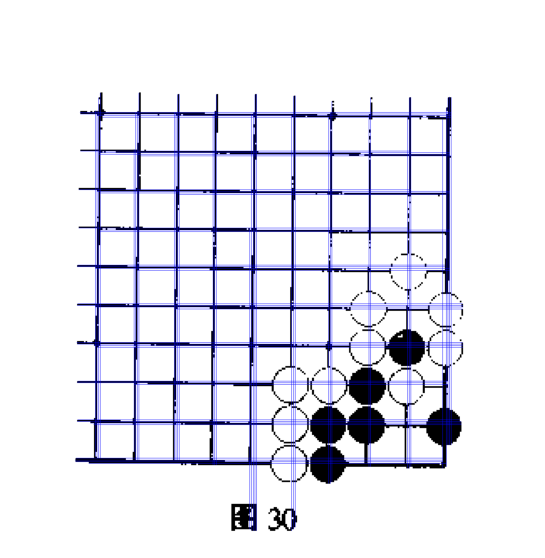

In [16]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
lines = all_lines(img_gray, 100)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [17]:
def get_verticals_horizontals(img_gray, hough_threshold):
        VERTICAL_TAN_MIN = 50
        HORIZONTAL_TAN_MAX = 0.02

        # Find all lines
        lines = all_lines(img_gray, hough_threshold)
        if (lines is None):
            return np.array([]), np.array([])
        # Divide the lines into verticals and horizontals
        v_lines = []
        h_lines = []
        for line in lines:
            x1, y1, x2, y2 = line
            if x1 == x2:
                line[1] = min(y1, y2)
                line[3] = max(y1, y2)
                v_lines.append(line)
            else:
                slope = (y2 - y1) / (x2 - x1)
                if abs(slope) > VERTICAL_TAN_MIN:
                    line[1] = min(y1, y2)
                    line[3] = max(y1, y2)
                    line[0] = line[2] = round(np.mean([x1, x2])) 
                    v_lines.append(line)
                elif abs(slope) < HORIZONTAL_TAN_MAX:
                    line[0] = min(x1, x2)
                    line[2] = max(x1, x2)
                    line[1] = line[3] = round(np.mean([y1, y2])) 
                    h_lines.append(line)
        v_lines = np.array(sorted(v_lines, key=lambda line: line[0]))
        h_lines = np.array(sorted(h_lines, key=lambda line: line[1]))
        return merge_lines(v_lines, True), merge_lines(h_lines, False)

In [18]:
def merge_lines(lines, is_vertical):
    MIN_DIST = 10 #?????
    
    if (lines.shape[0] == 0):
        return np.array([])
    ind =  0 if is_vertical else 1
    is_close = np.diff(lines, axis=0)[:, ind] <= MIN_DIST
    merged_lines = []
    i = 0
    while i < lines.shape[0]:
        close_lines = [lines[i]]
        while i + 1 < lines.shape[0] and is_close[i]:
            i += 1
            close_lines.append(lines[i])
        close_lines = np.array(close_lines)
        if is_vertical:
            x = round(np.mean(close_lines[:, ind]))
            merged_line = [x, np.amin(close_lines[:, 1]), x, np.amax(close_lines[:, 3])]
        else:
            y = round(np.mean(close_lines[:, ind]))
            merged_line = (np.amin(close_lines[:, 0]), y, np.amax(close_lines[:, 2]), y)
        merged_lines.append(merged_line)
        i += 1
    return np.array(merged_lines)

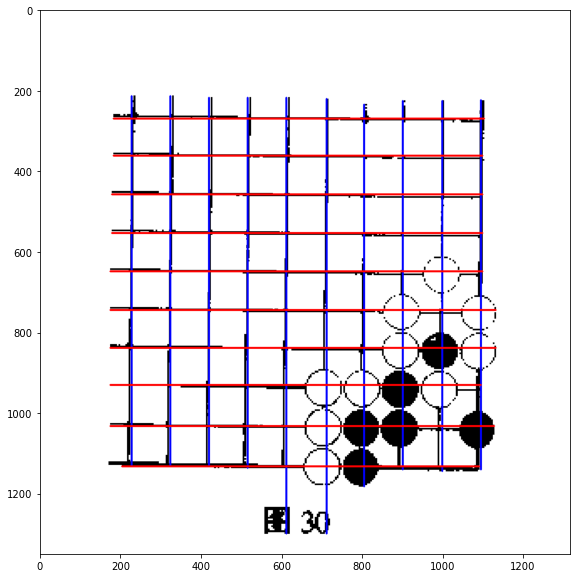

In [19]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines =  get_verticals_horizontals(img_gray, 273)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.show()

In [20]:
def lines_recognition(img_gray):
        HOUGH_LOW_THRESHOLD = 50
        HOUGH_THRESHOLD_STEP = 15
        
        clear_v_lines, clear_h_lines = [], []
        hough_threshold = min(img_gray.shape[0:2])
        while hough_threshold > HOUGH_THRESHOLD_STEP:
            clear_v_lines, clear_h_lines = get_verticals_horizontals(img_gray, hough_threshold)
            if ((len(clear_v_lines) > 1) and (len(clear_h_lines) > 1)):
                dists_x = np.diff(clear_v_lines[:, 0])
                dists_y = np.diff(clear_h_lines[:, 1])
                cell_size_1 = np.amin(dists_x)
                cell_size_2 = np.amin(dists_y)
                cell_size = min(cell_size_1, cell_size_2)
                if (cell_size / max(cell_size_1, cell_size_2) > 0.9):
                    dists = np.concatenate([dists_x, dists_y])
                    fracs = np.modf(dists / cell_size)[0]
                    cell_size = np.mean(dists[np.round(dists / cell_size) ==  1])
                    while hough_threshold > HOUGH_THRESHOLD_STEP:
                        hough_threshold -= HOUGH_THRESHOLD_STEP
                        clear_v_lines, clear_h_lines = get_verticals_horizontals(img_gray, hough_threshold)
                        dists_x = np.diff(clear_v_lines[:, 0])
                        dists_y = np.diff(clear_h_lines[:, 1])
                        dists = np.concatenate([dists_x, dists_y])
                        fracs = np.modf(dists / cell_size)[0]
                        if np.any(np.logical_and(fracs < 0.8, fracs > 0.2)):
                            hough_threshold += HOUGH_THRESHOLD_STEP
                            clear_v_lines, clear_h_lines = get_verticals_horizontals(img_gray, hough_threshold)
                            break
                        else:
                            cell_size = np.mean(dists[np.round(dists / cell_size) ==  1])
                    break
            hough_threshold -= HOUGH_THRESHOLD_STEP
        # Add unclear lines
        # possible bugs!
        #print(hough_threshold)
        unclear_v_lines, unclear_h_lines = get_verticals_horizontals(img_gray, HOUGH_LOW_THRESHOLD)
        x_min = min(unclear_v_lines[0][0], clear_v_lines[0][0])
        y_min = min(unclear_h_lines[0][1], clear_h_lines[0][1])
        x_max = max(unclear_v_lines[-1][0], clear_v_lines[-1][0])
        y_max = max(unclear_h_lines[-1][1], clear_h_lines[-1][1])
        
        x_min_line = np.mean(clear_h_lines[:, 0])
        x_max_line = np.mean(clear_h_lines[:, 2])
        y_min_line = np.mean(clear_v_lines[:, 1])
        y_max_line = np.mean(clear_v_lines[:, 3])
        
        v_lines = []
        xs = np.concatenate([[x_min], clear_v_lines[:, 0], [x_max]])
        dists = np.diff(xs)
        num_lines = (dists / cell_size).astype(int)
        num_lines[np.modf(dists / cell_size)[0] > 0.8] += 1
        num_lines[1:-1][num_lines[1:-1] != 0] -= 1
        #print(num_lines)
        #print(dists / cell_size)
        for i in range(1, xs.size):
            for ind in range(1, num_lines[i - 1] + 1):
                if i == xs.size - 1:
                    x = xs[i - 1] + np.round(ind * dists[-1] / num_lines[-1])
                elif i == 1:
                    x = xs[i] - np.round((num_lines[0] + 1 - ind) * dists[0] / num_lines[0])
                else:
                    x = xs[i] - np.round((num_lines[i - 1] + 1 - ind) * dists[i - 1] / (num_lines[i - 1] + 1))
                new_line = [x, y_min_line, x, y_max_line]
                v_lines.append(new_line)
            if i != xs.size - 1:
                v_lines.append(clear_v_lines[i - 1])
        h_lines = []
        ys = np.concatenate([[y_min], clear_h_lines[:, 1], [y_max]])
        dists = np.diff(ys)
        num_lines = (dists / cell_size).astype(int)
        num_lines[np.modf(dists / cell_size)[0] > 0.8] += 1
        num_lines[1:-1][num_lines[1:-1] != 0] -= 1
        #print(num_lines)
        #print(dists / cell_size)
        for i in range(1, ys.size):
            for ind in range(1, num_lines[i - 1] + 1):
                if i == ys.size - 1:
                    y = ys[i - 1] + np.round(ind * dists[-1] / num_lines[-1])
                elif i == 1:
                    y = ys[i] - np.round((num_lines[0] + 1 - ind) * dists[0] / num_lines[0])
                else:
                    y = ys[i] - np.round((num_lines[i - 1] + 1 - ind) * dists[i - 1] / (num_lines[i - 1] + 1))
                new_line = [x_min_line, y, x_max_line, y]
                h_lines.append(new_line)
            if i != ys.size - 1:
                h_lines.append(clear_h_lines[i - 1])
        return np.array(v_lines).astype(int), np.array(h_lines).astype(int)

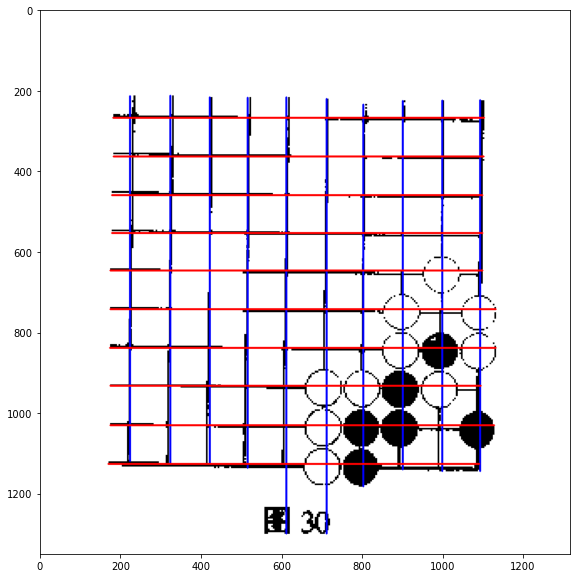

In [21]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
v_lines, h_lines = lines_recognition(img_gray)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
plt.imshow(to_RGB(img))
plt.show() 

In [22]:
def get_cell_size(v_lines, h_lines):
    return round(np.mean([(np.ptp(v_lines[:, 0]) / (v_lines.shape[0] - 1)),
                          (np.ptp(h_lines[:, 1]) / (h_lines.shape[0] - 1))]))

In [23]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T

In [24]:
def find_edges(v_lines, h_lines, cell_size):
        #????
        MIN_DIFF = 0.3

        up_line = h_lines[0]
        #print(up_line[1] - v_lines[:, 1] > cell_size * MIN_DIFF)
        up_edge = np.sum(up_line[1] - v_lines[:, 1] > cell_size * MIN_DIFF) < (v_lines.shape[0] / 1.5)

        down_line = h_lines[-1]
        #print(v_lines[:, 3] - down_line[1] > MIN_DIFF)
        down_edge = np.sum(v_lines[:, 3] - down_line[1] > cell_size * MIN_DIFF) < (v_lines.shape[0] / 1.5)

        left_line = v_lines[0]
        left_edge = np.sum(left_line[0] - h_lines[:, 0] > cell_size * MIN_DIFF) < (h_lines.shape[0] / 1.5)

        right_line = v_lines[-1]
        #print(h_lines[:, 2] - right_line[0] > MIN_DIFF)
        right_edge = np.sum(h_lines[:, 2] - right_line[0] > cell_size * MIN_DIFF) < (h_lines.shape[0] / 1.5)
        return up_edge, down_edge, left_edge, right_edge

In [25]:
intersections = find_intersections(v_lines, h_lines)

In [26]:
cell_size = get_cell_size(v_lines, h_lines)
cell_size

96

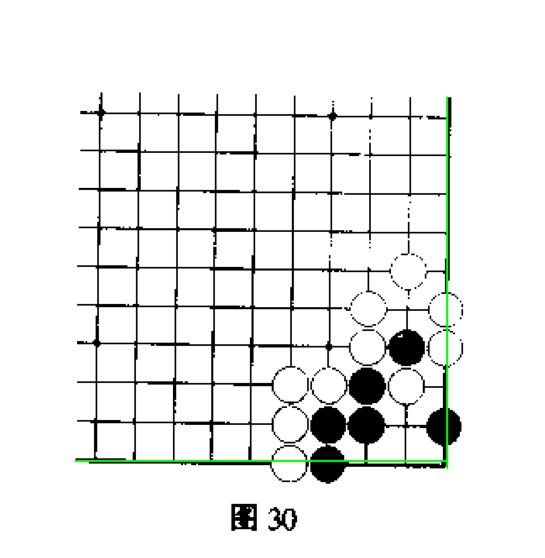

In [27]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
up_edge, down_edge, left_edge, right_edge = find_edges(v_lines, h_lines, cell_size)
if up_edge:
    line = h_lines[0]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if down_edge:
    line = h_lines[-1]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if left_edge:
    line = v_lines[0]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if right_edge:
    line = v_lines[-1]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
plt.imshow(to_RGB(img))
plt.axis('off')
plt.show() 

In [28]:
def find_circles(img_gray, param2, min_dist_coeff, min_r_coeff, max_r_coeff, cell_size):
        METHOD = cv2.HOUGH_GRADIENT
        DP = 2
        PARAM1 = 200

        circles = cv2.HoughCircles(img_gray, method=METHOD, dp=DP,
                                minDist=round(cell_size * min_dist_coeff),
                                param1=PARAM1, param2=param2, minRadius=round(cell_size * min_r_coeff),
                                maxRadius=round(cell_size * max_r_coeff))
        if circles is None:
            return None
        return circles[0, :]

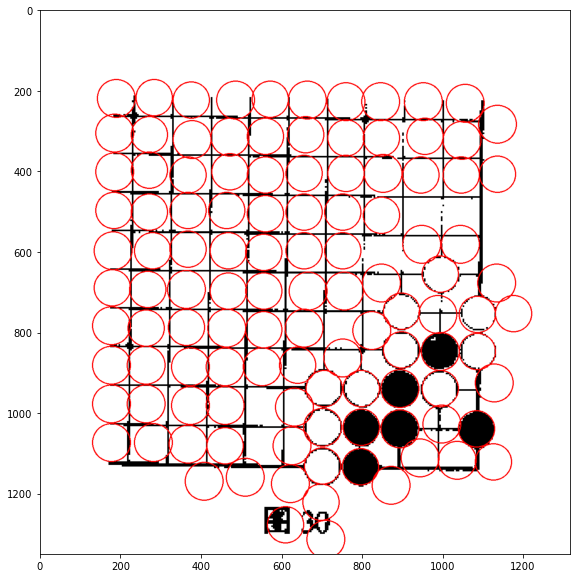

In [29]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
circles = find_circles(img_gray, 5, 0.9, 0.45, 0.5, cell_size)

img = cv2.imread(path, cv2.IMREAD_COLOR)
for circle in circles:
    cv2.circle(img ,(circle[0],circle[1]), round(circle[2]),(0,0,255),2)

plt.imshow(to_RGB(img))
plt.show()

In [365]:
def stones_recognition(img_gray, cell_size, intersections):
        MIN_INTERSECTION_DIST_COEFF = 0.2
        
        all_circles = []
        param2_grid = np.linspace(5, 30, 6)
        min_dist_coeff_grid = np.linspace(0.9, 0.9, 1)
        min_r_coeff_grid = np.linspace(0.4, 0.45, 2)
        max_r_coeff_grid = np.linspace(0.5, 0.55, 2)
        grid_size = param2_grid.size * min_dist_coeff_grid.size *  min_r_coeff_grid.size *  max_r_coeff_grid.size
        grid = np.array(np.meshgrid(param2_grid,
                                    min_dist_coeff_grid,
                                    min_r_coeff_grid,
                                    max_r_coeff_grid)
                       ).T.reshape(-1,4)
        for param2,min_dist_coeff,min_r_coeff, max_r_coeff  in grid:
            circles = find_circles(img_gray,param2,min_dist_coeff,min_r_coeff, max_r_coeff, cell_size)
            if circles is not None:
                all_circles.append(circles)
        circles = np.concatenate(all_circles)
        # Filter circles
        stones = defaultdict(list)
        radii = []
        for circle in circles:
            for intersection in np.reshape(intersections, (-1, 2)):
                if np.linalg.norm(circle[:2] - intersection) <= MIN_INTERSECTION_DIST_COEFF * cell_size:
                    stones[tuple(intersection)].append(circle[:2])
                    radii.append(circle[2])
                    break
        for intersection in stones.keys():
            stones[intersection] = np.round(np.mean(np.array(stones[intersection]), axis=0)).astype(int)
        return stones, round(np.mean(radii))

In [366]:
'''
def colorize(img_gray, stones, radius):
    WHITE_WITH_NO_SIGNS_THRESHOLD = 250
    CROSS_THRESHOLD = 180
    WHITE_WITH_SIGN_THRESHOLD = 120
    white_stones = []
    black_stones = []
    width = radius // 10
    for stone_inter in stones.keys():
        stone = stones[stone_inter]
        stone_mask = np.zeros((img_gray.shape[0], img_gray.shape[1]), np.uint8)
        cv2.circle(stone_mask,(stone[0],stone[1]), round(radius * 0.8), 255 ,-1)
        average_color = cv2.mean(img_gray, mask=stone_mask)[0]
        if average_color >= WHITE_WITH_NO_SIGNS_THRESHOLD:
            white_stones.append(stone)
            print(average_color)
        elif average_color >= CROSS_THRESHOLD:
            average_color_left = np.mean(img_gray[stone_inter[1] - radius: stone_inter[1],
                                                  stone_inter[0] - width : stone_inter[0] + width])
            average_color_right = np.mean(img_gray[stone_inter[1]: stone_inter[1] + radius,
                                                    stone_inter[0] - width : stone_inter[0] + width])
            average_color_up = np.mean(np.mean(img_gray[stone_inter[1] - width: stone_inter[1] + width,
                                                        stone_inter[0] - radius : stone_inter[0]]))
            average_color_down = np.mean(img_gray[stone_inter[1] - width: stone_inter[1] + width,
                                                        stone_inter[0] : stone_inter[0] + radius])
            if np.sum([average_color_left <= 200, average_color_right <= 200,
                       average_color_up <= 200, average_color_down <= 200]) >= 2:
                pass
            else:
                #print([average_color_left, average_color_right, average_color_up, average_color_down])
                white_stones.append(stone)                           
        elif average_color >= WHITE_WITH_SIGN_THRESHOLD:
            #print(average_color)
            white_stones.append(stone)
        else:
            black_stones.append(stone)
    return np.array(white_stones), np.array(black_stones)
'''
pass

In [3]:
def colorize(img_gray, stones, radius):
        WHITE_THRESHOLD = 250
        BLACK_THRESHOLD = 5

        white_stones = []
        black_stones = []
        for stone in stones.values():
            stone_mask = np.zeros((img_gray.shape[0], img_gray.shape[1]), np.uint8)
            cv2.circle(stone_mask,(stone[0],stone[1]), radius // 2, 255 ,-1)
            average_color = cv2.mean(img_gray, mask=stone_mask)[0]
            if average_color >= WHITE_THRESHOLD:
                white_stones.append(stone)
            elif average_color <= BLACK_THRESHOLD:
                black_stones.append(stone)
        return np.array(white_stones), np.array(black_stones)

In [4]:
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
stones, radius = stones_recognition(img_gray, cell_size, intersections)
img = cv2.imread(path, cv2.IMREAD_COLOR)

white_stones, black_stones = colorize(img_gray,stones, radius)

for stone in white_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),2)
for stone in black_stones:
    cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),2)

plt.imshow(to_RGB(img))
plt.axis('off')
plt.show()

NameError: name 'stones_recognition' is not defined

In [4]:
import sys  
sys.path.insert(0, './src')

In [5]:
import recognizer
r = recognizer.Recognizer()

In [6]:
def visualize(img):
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        v_lines, h_lines = lines_recognition(img_gray)
        intersections = find_intersections(v_lines, h_lines)
        cell_size = get_cell_size(v_lines, h_lines)
        edges = find_edges(v_lines, h_lines, cell_size)
        stones, radius = stones_recognition(img_gray, cell_size, intersections)
        white_stones, black_stones = colorize(img_gray, stones, radius)
        
        for intersection in np.reshape(intersections, (-1, 2)):
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
            
        up_edge, down_edge, left_edge, right_edge = edges
        if up_edge:
            for intersection in intersections[:, 0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if down_edge:
            for intersection in intersections[:, -1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if left_edge:
            for intersection in intersections[0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if right_edge:
            for intersection in intersections[-1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()

In [7]:
def visualize_r(img, r):
    try:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        intersections, white_stones, black_stones, radius, x_size, y_size, edges = r.recognize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
        for intersection in np.reshape(intersections, (-1, 2)):
            cv2.circle(img, (intersection[0], intersection[1]), 5, (255,0,255), -1)
            
        up_edge, down_edge, left_edge, right_edge = edges
        if up_edge:
            for intersection in intersections[:, 0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if down_edge:
            for intersection in intersections[:, -1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if left_edge:
            for intersection in intersections[0]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        if right_edge:
            for intersection in intersections[-1]:
                cv2.circle(img, (intersection[0], intersection[1]), 5, (0, 255, 0), -1)
        
        for stone in white_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),3)
        for stone in black_stones:
            cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),3)
        plt.subplot(1, 2, 2)
        plt.imshow(to_RGB(img))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(e)

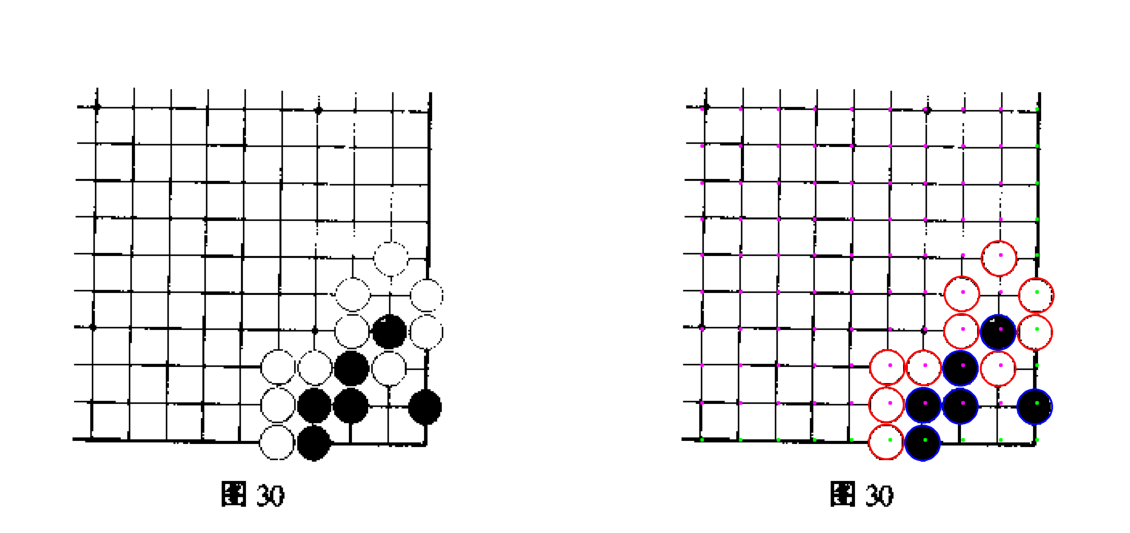

In [8]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
visualize_r(img, r)

f_3.png


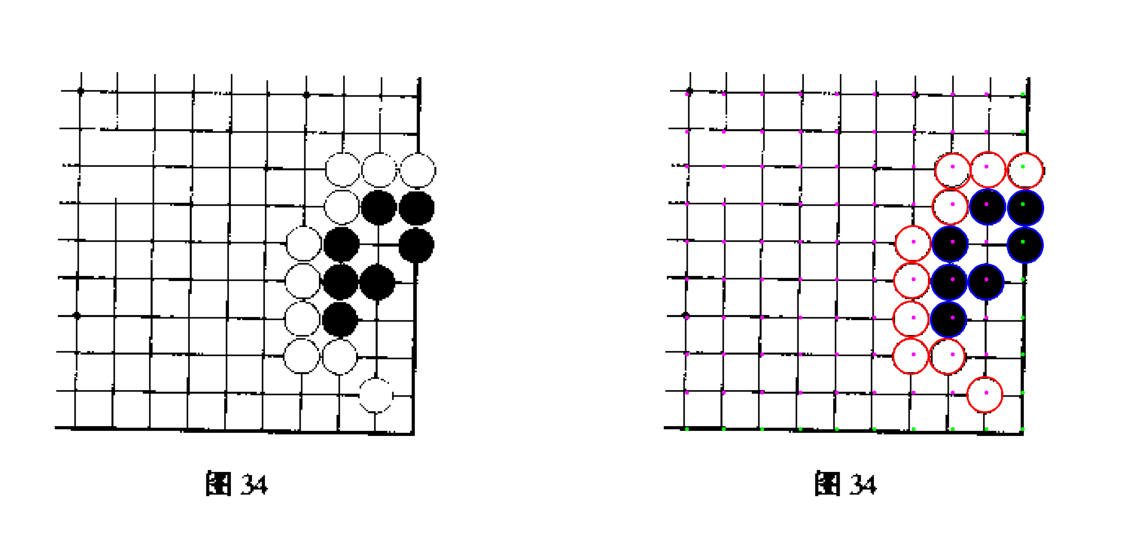

f_2.png


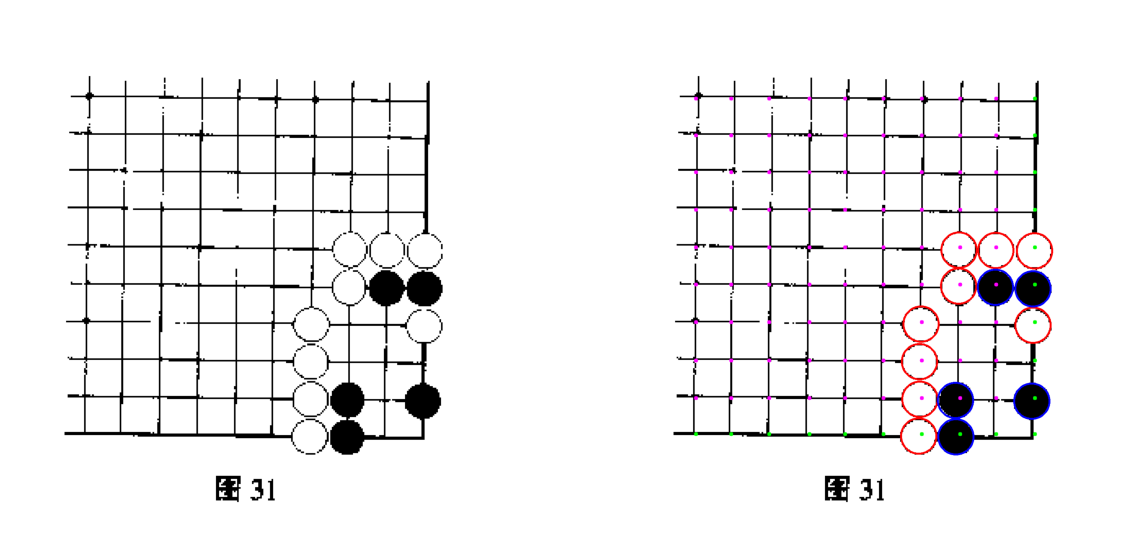

f_0.png


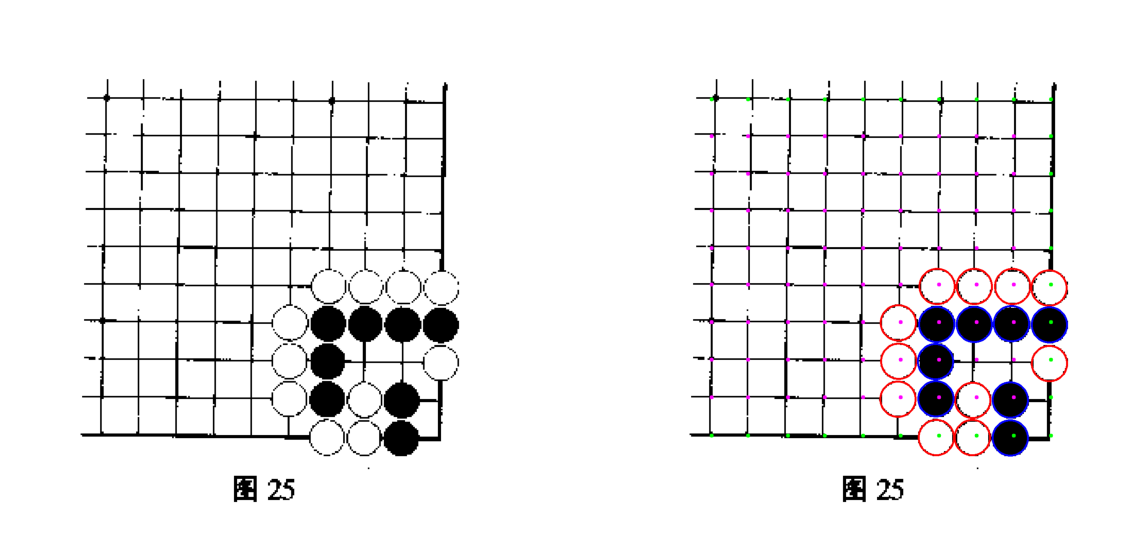

f_1.png


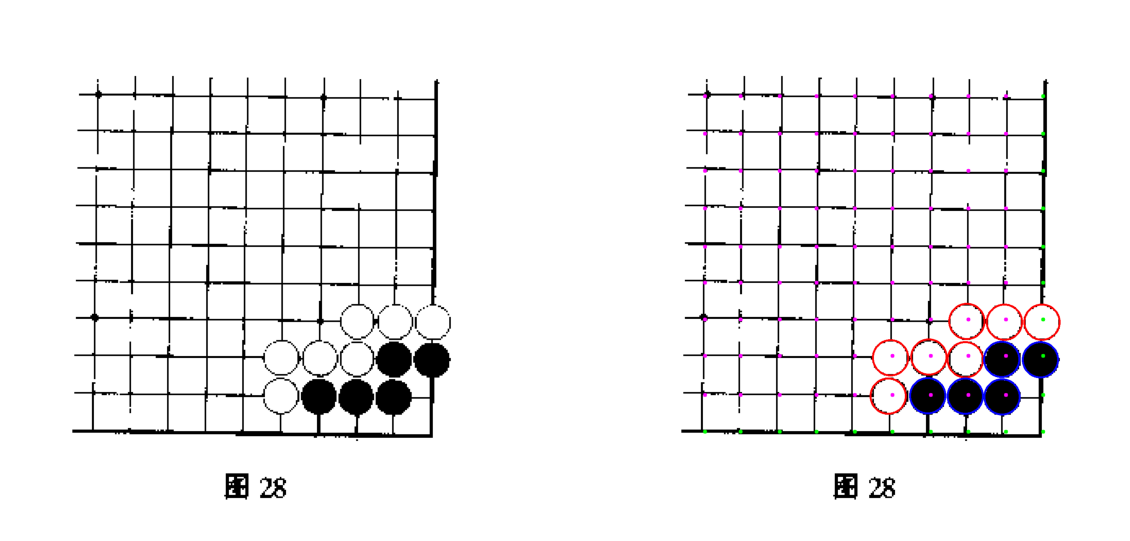

f_5.png


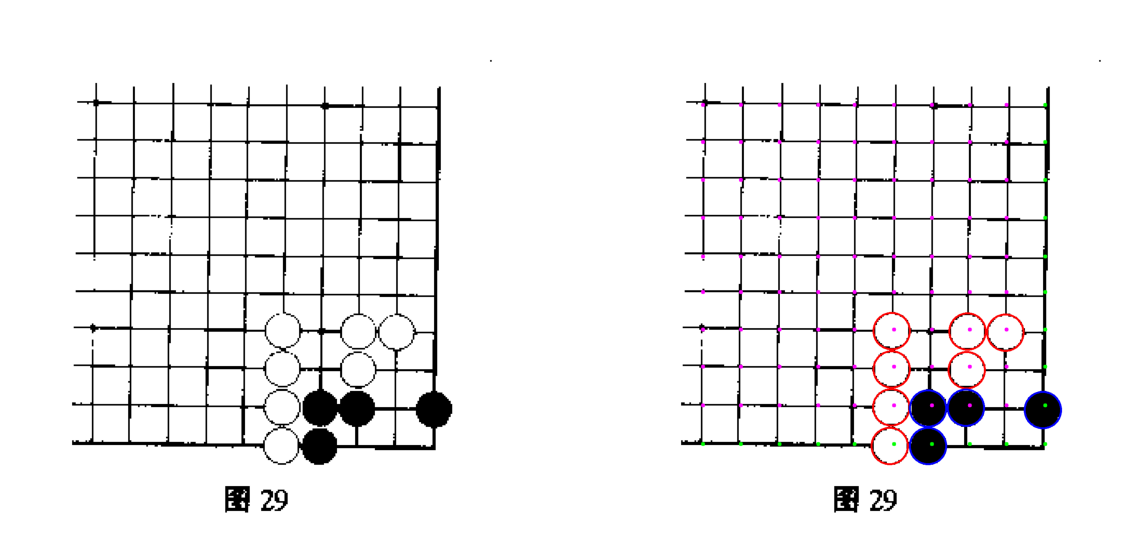

f_4.png


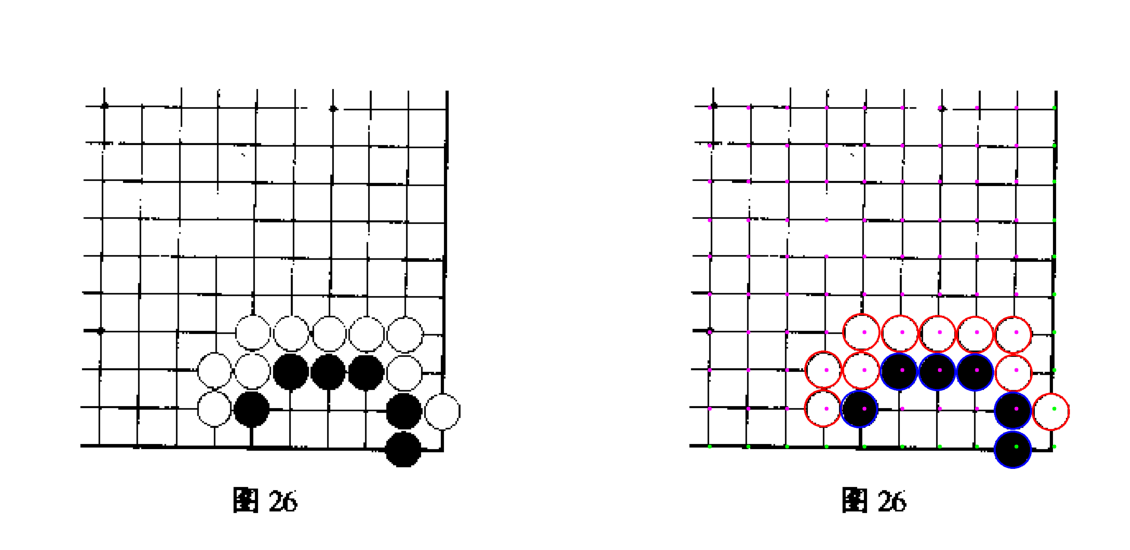

f_6.png


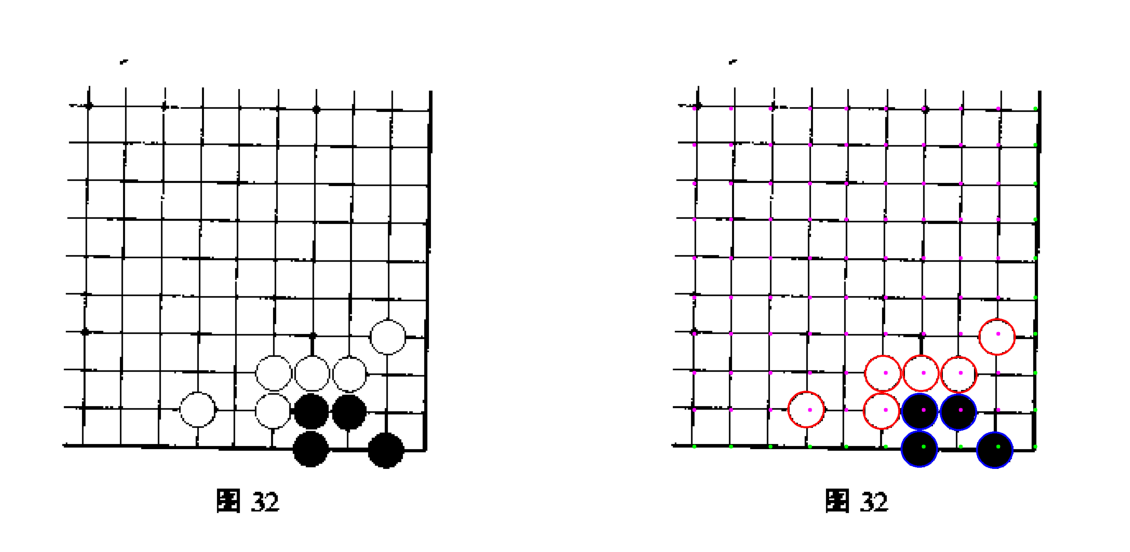

f_7.png


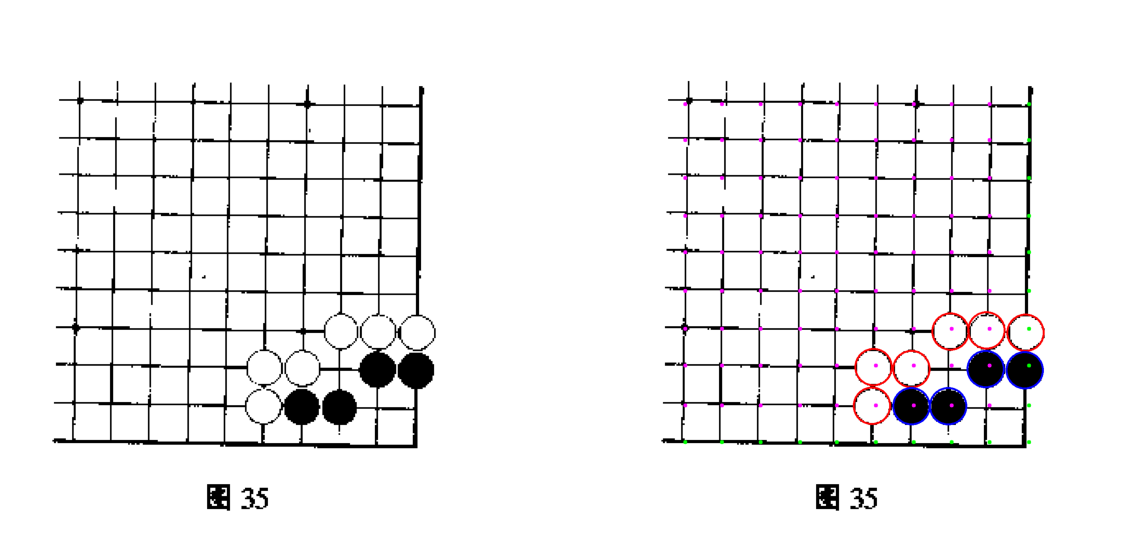

f_9.png


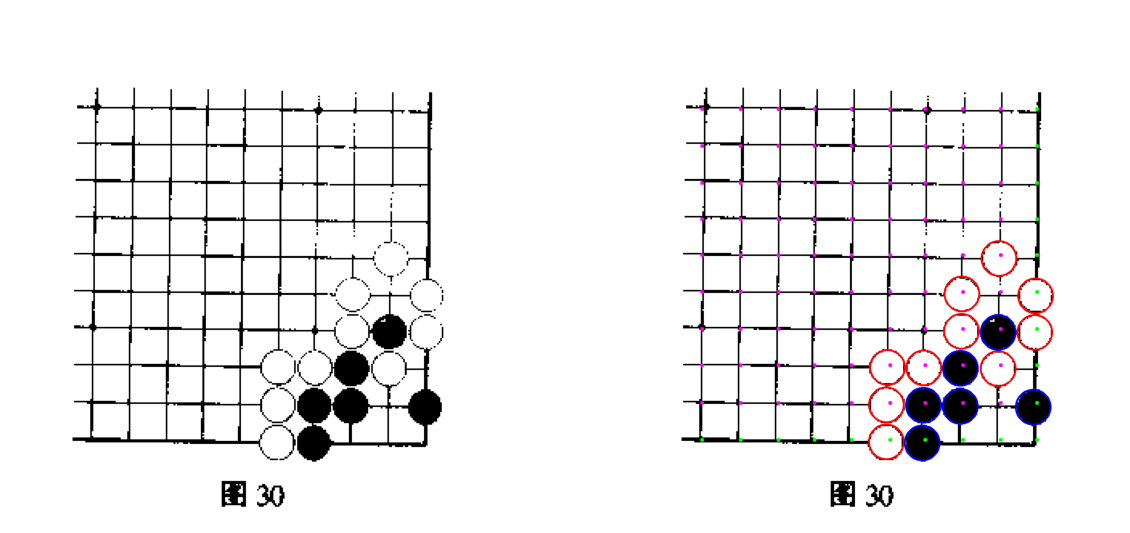

f_8.png


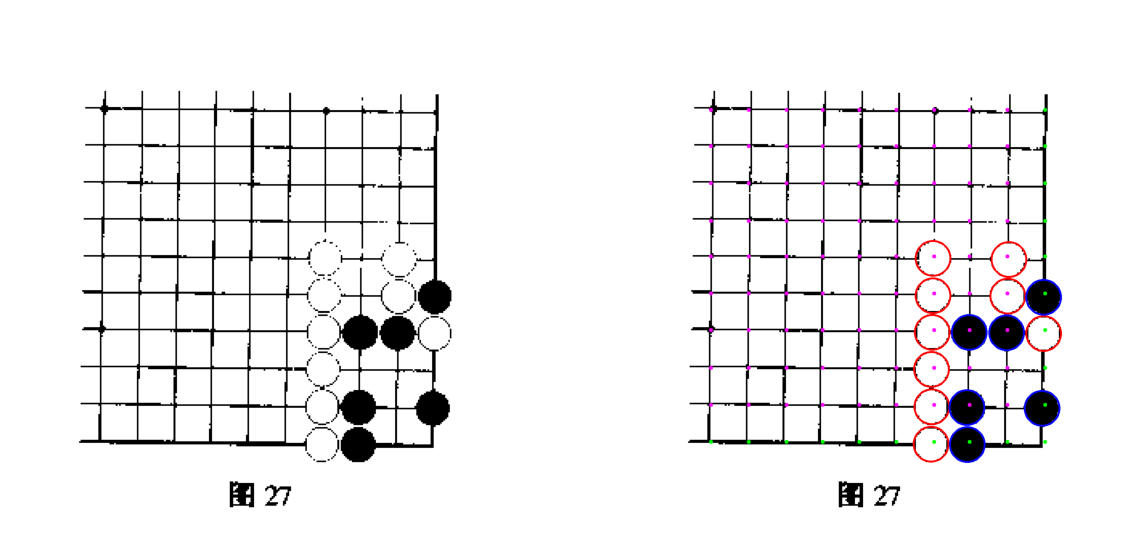

f_11.png


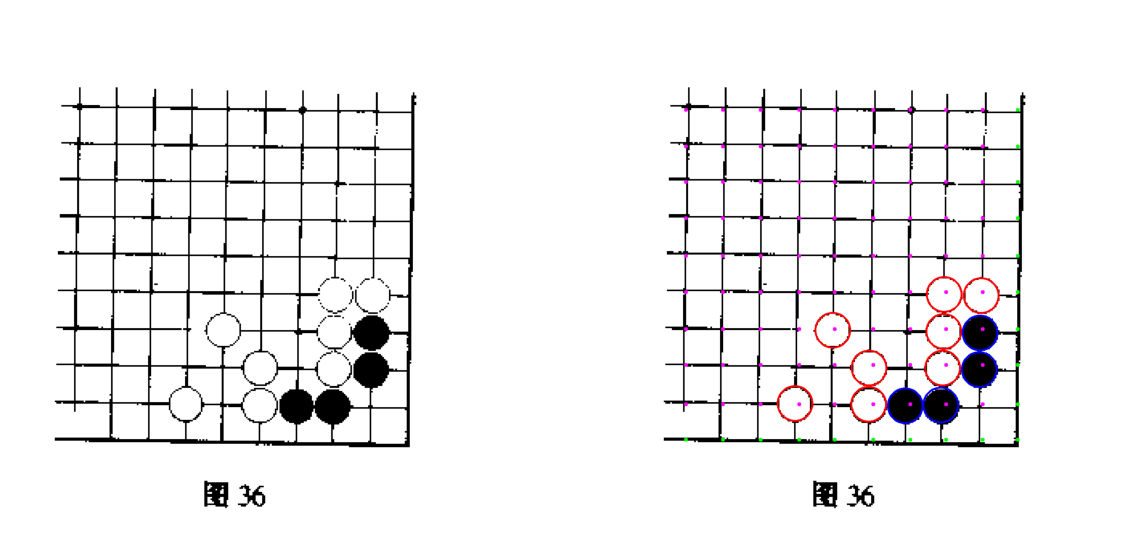

f_10.png


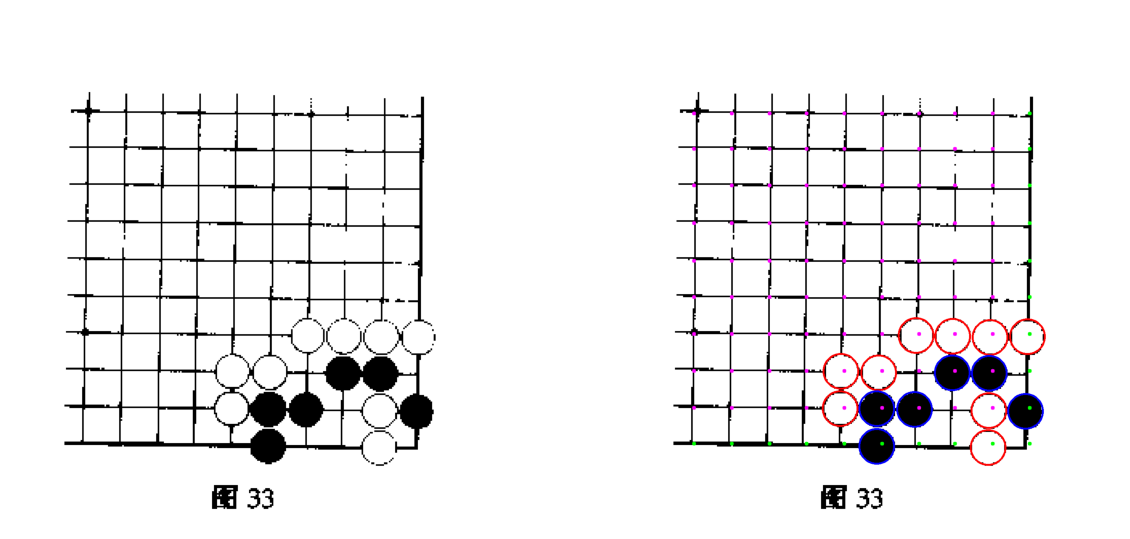

In [332]:
img_files = glob.glob('f_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize_r(img, r)

k_10.png


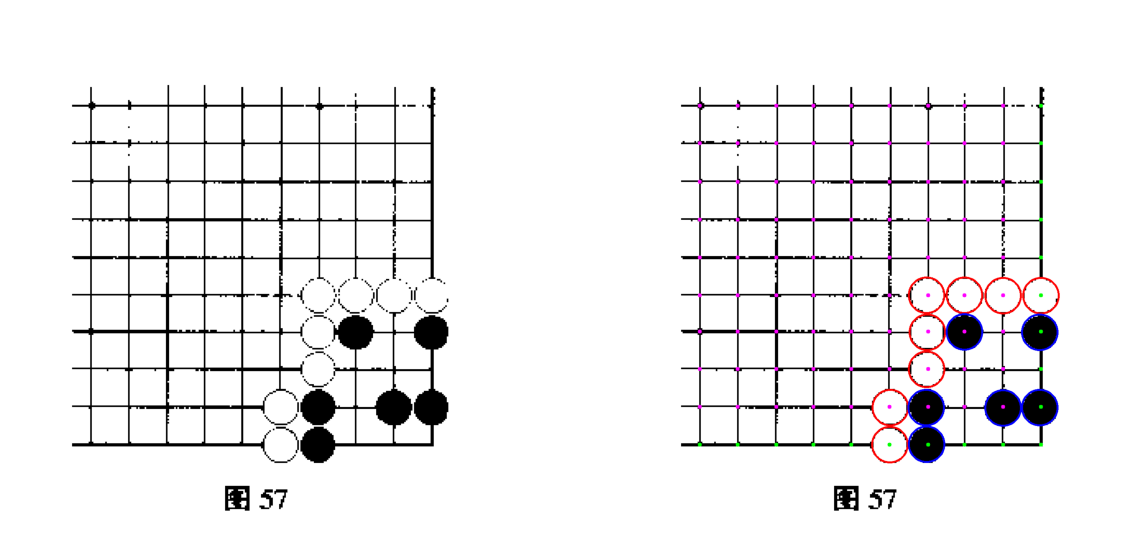

k_11.png


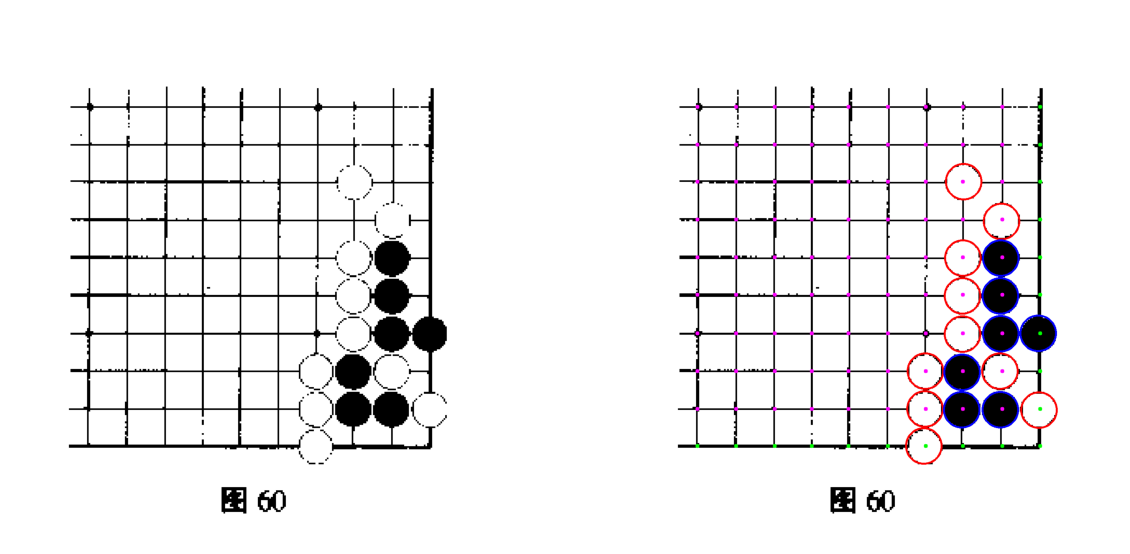

k_8.png


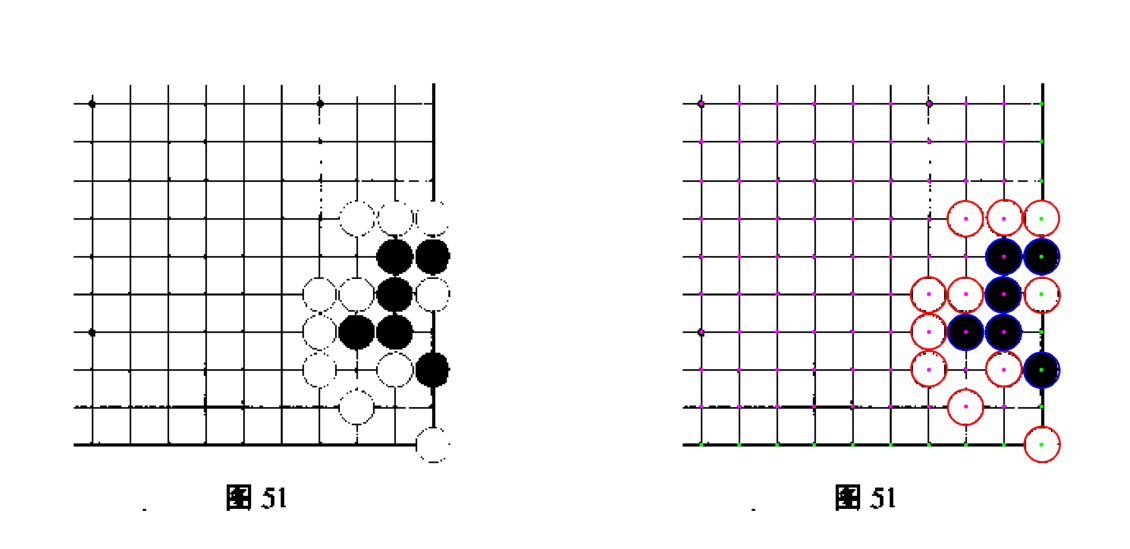

k_9.png


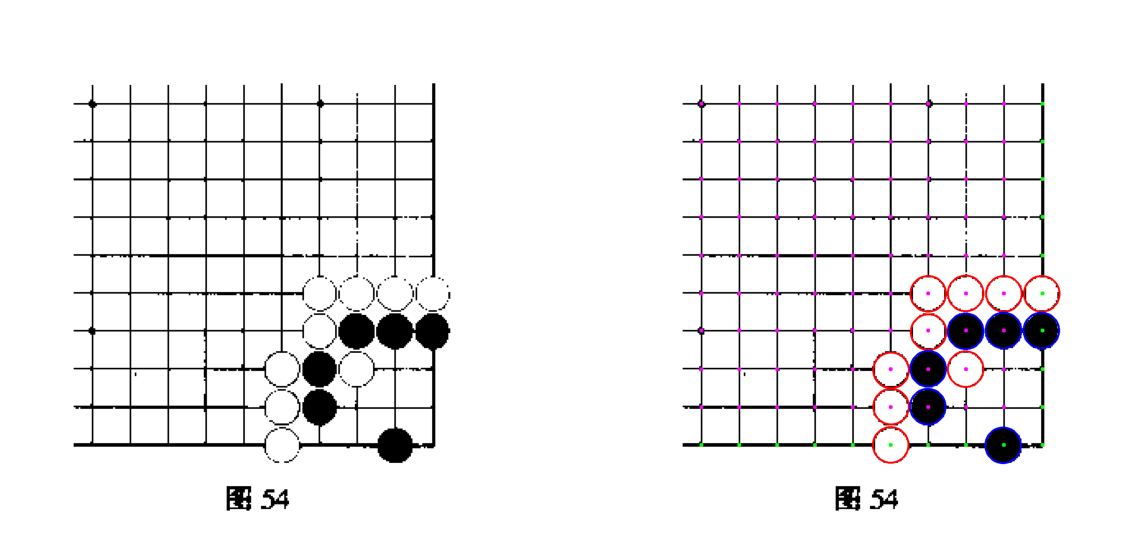

k_4.png


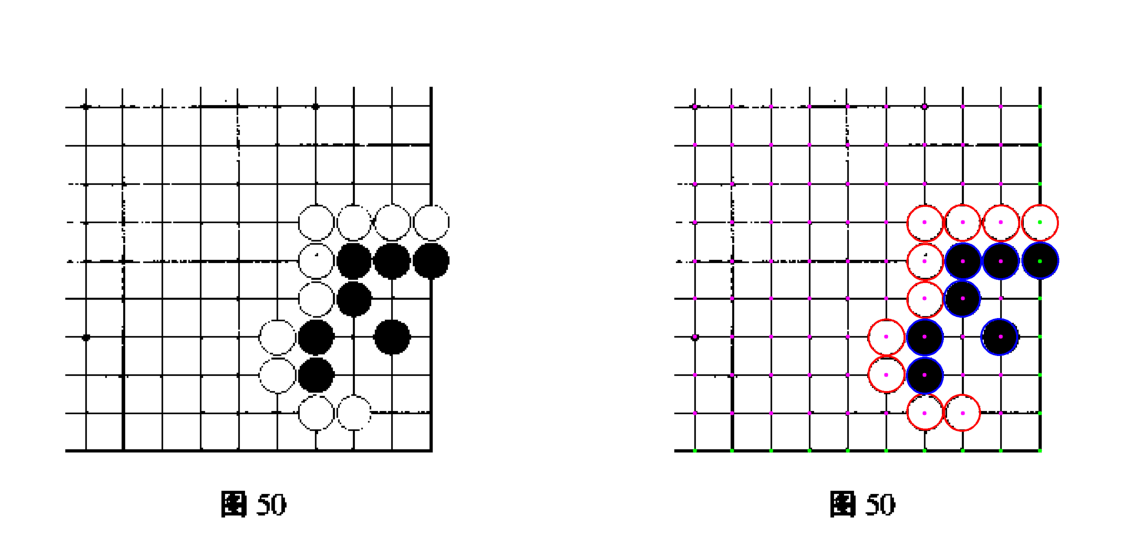

k_5.png


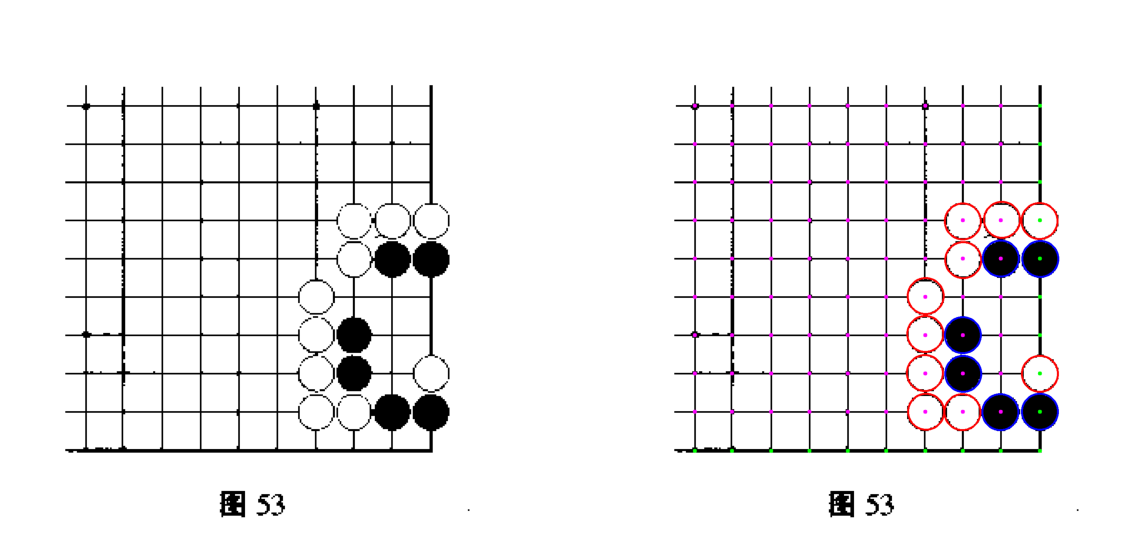

k_7.png


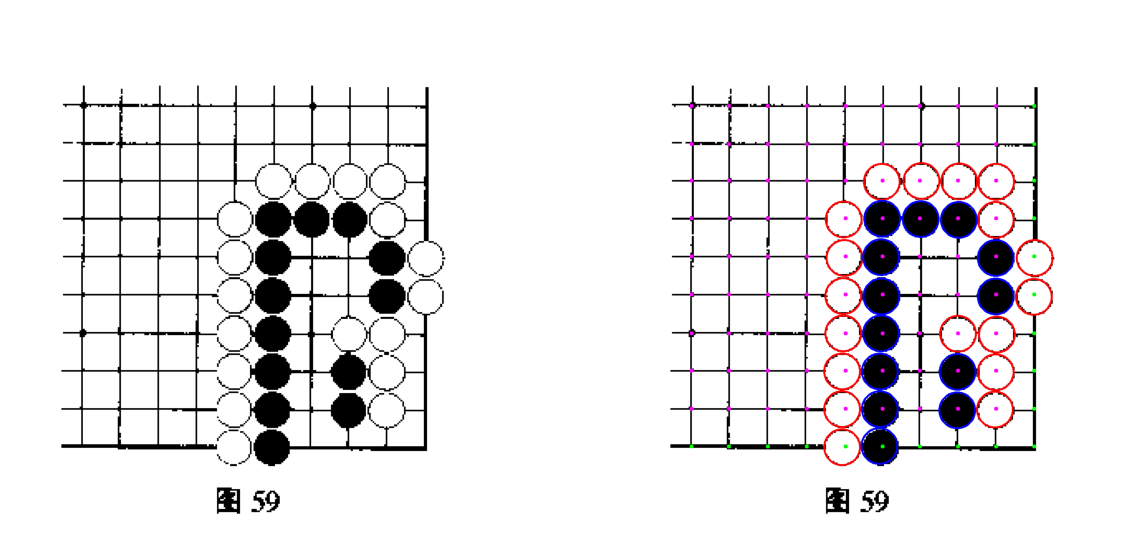

k_6.png


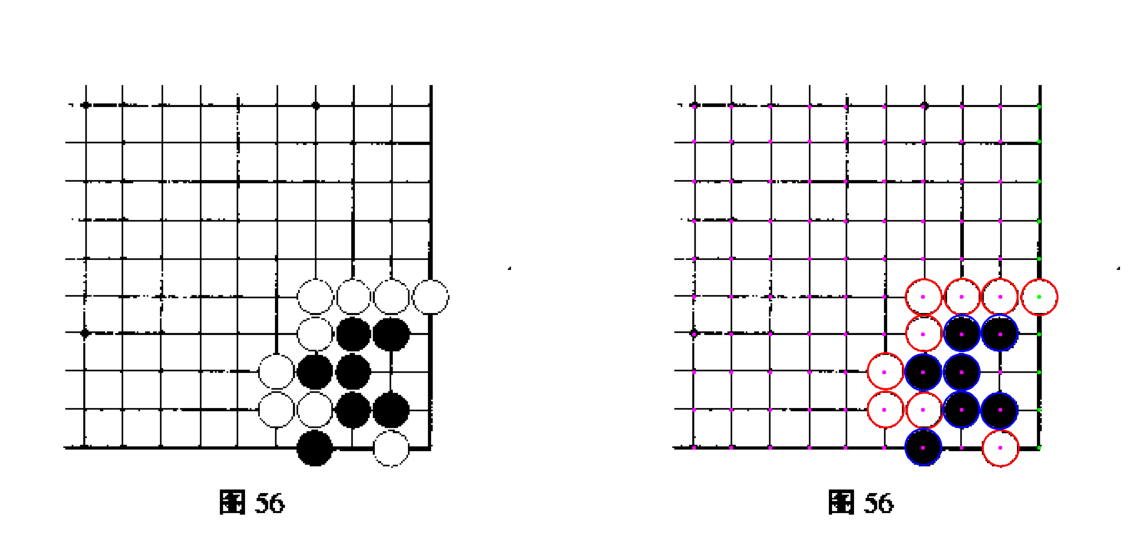

k_2.png


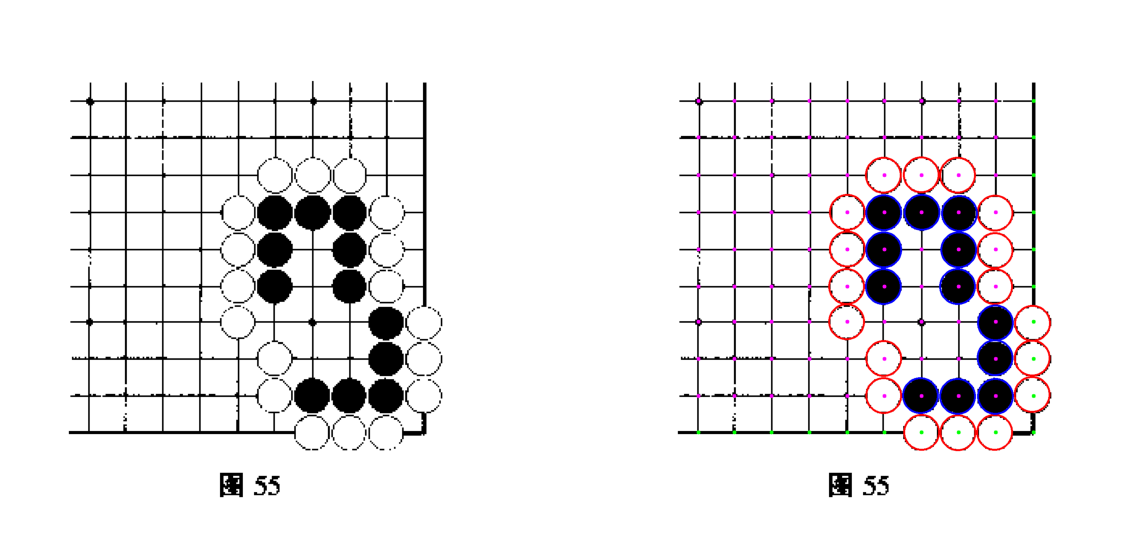

k_3.png


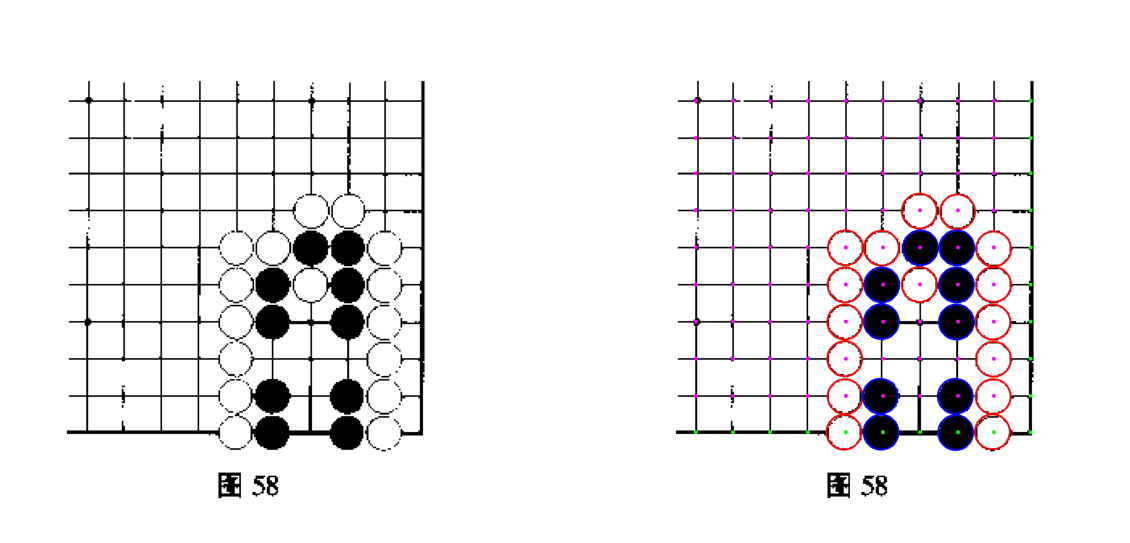

k_1.png


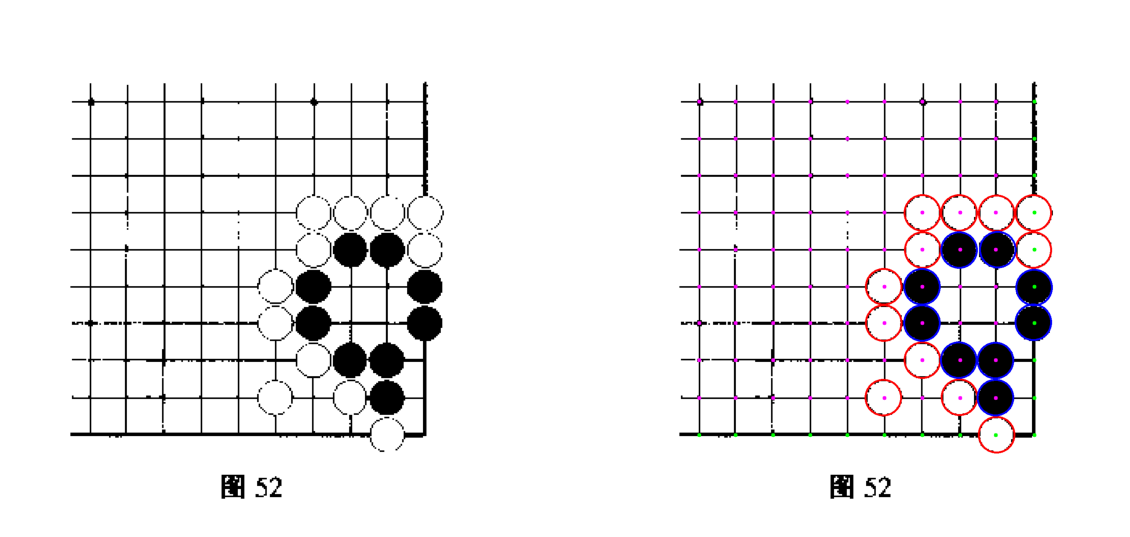

k_0.png


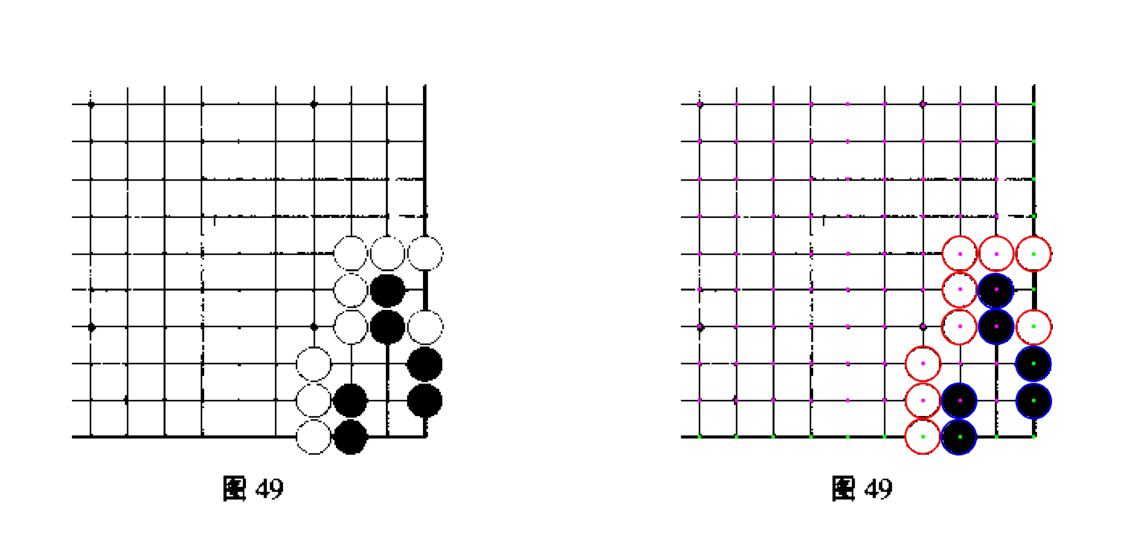

In [9]:
img_files = glob.glob('k_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize_r(img, r)

data/images/chinese/8.png


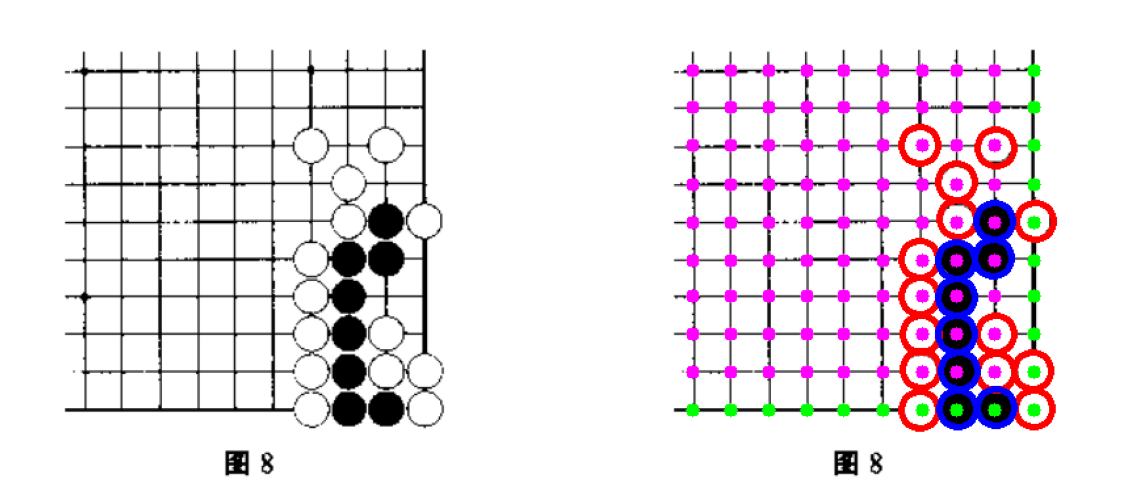

data/images/chinese/9.png


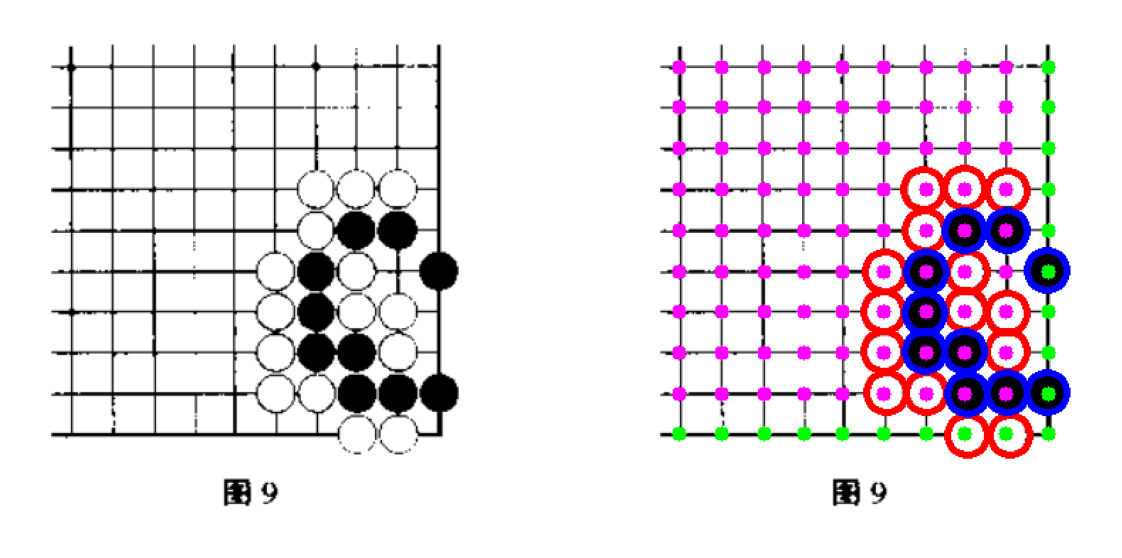

data/images/chinese/12.png


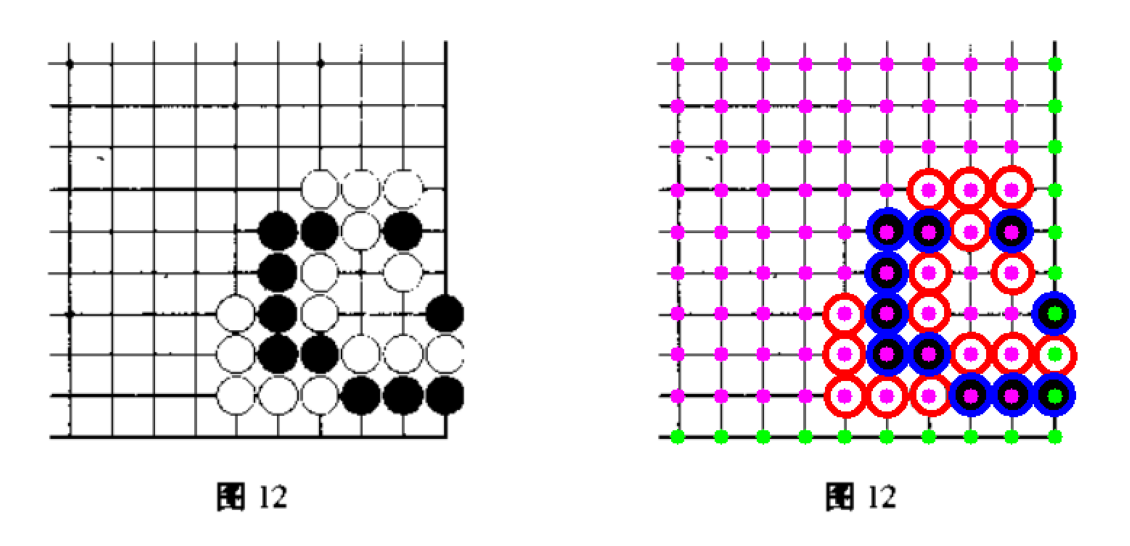

data/images/chinese/11.png


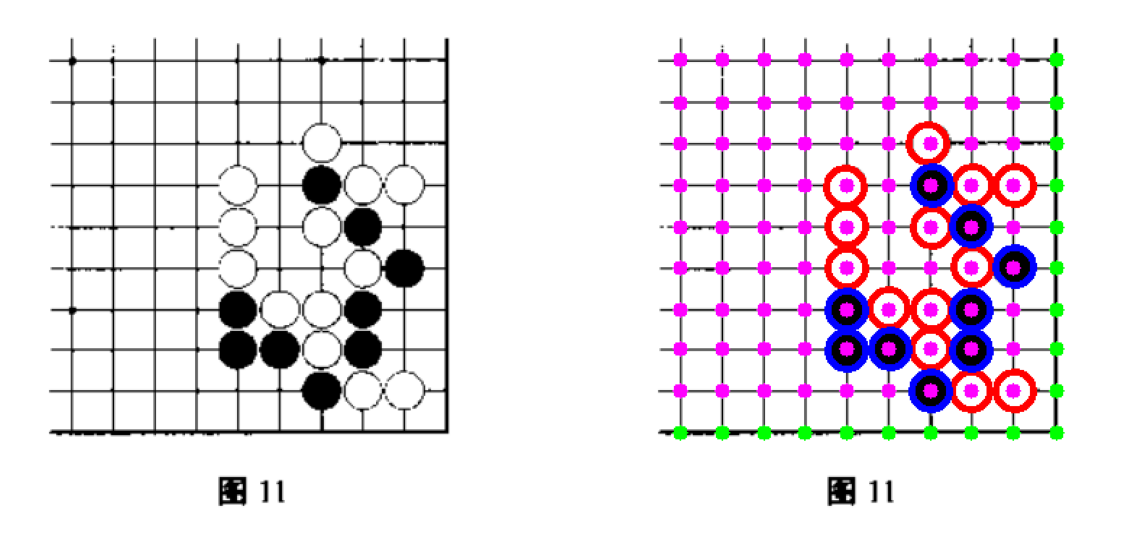

data/images/chinese/10.png


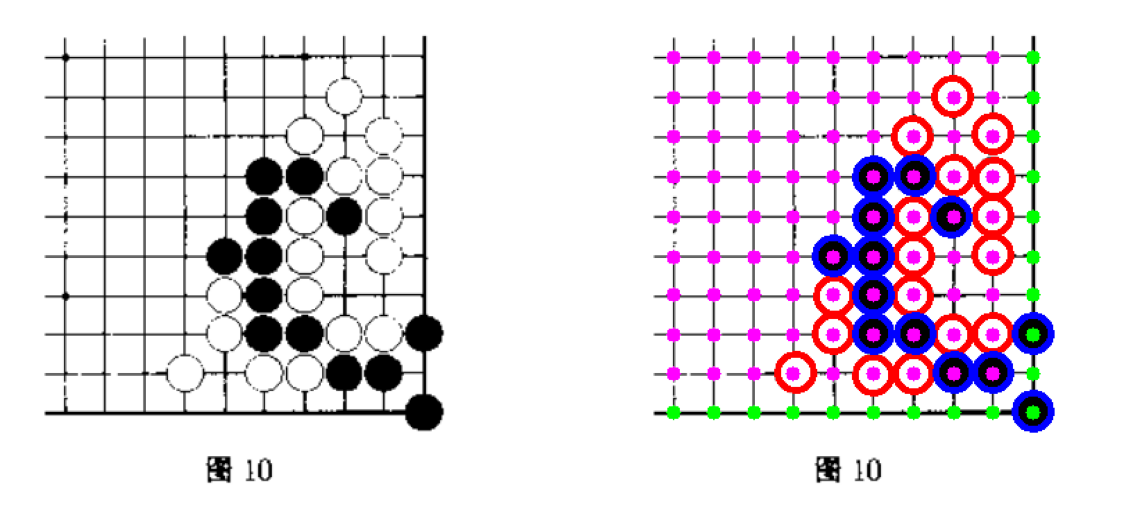

data/images/chinese/4.png


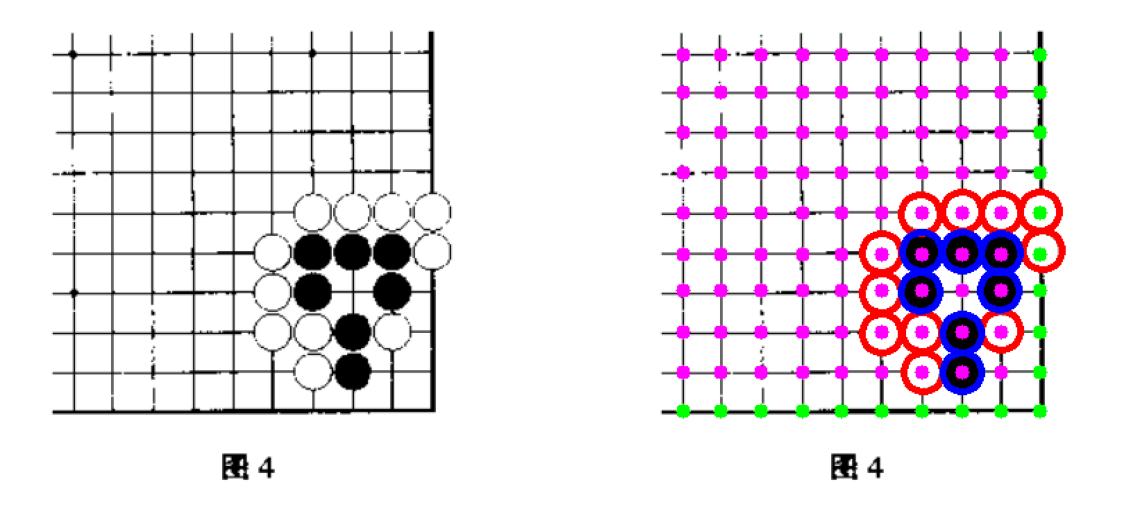

data/images/chinese/5.png


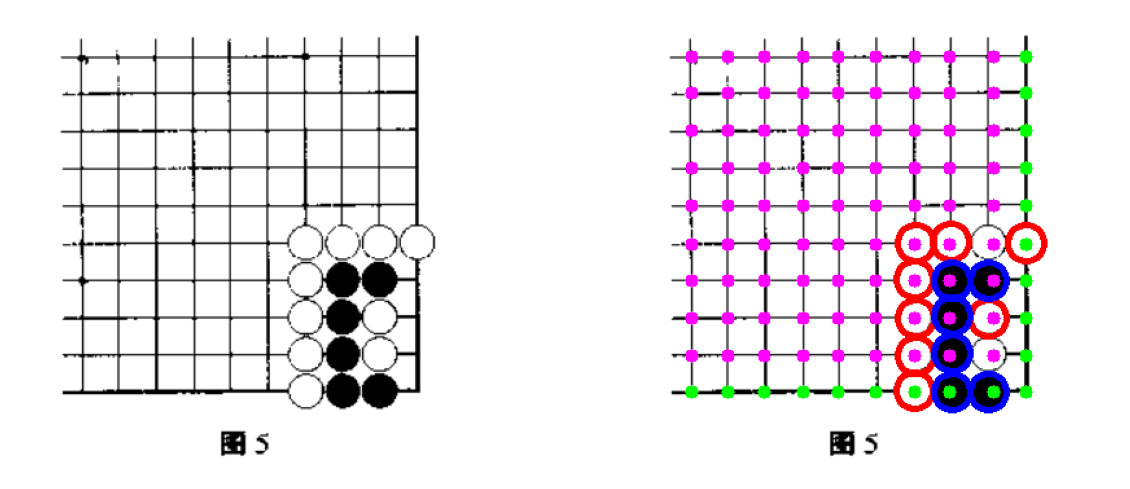

data/images/chinese/7.png


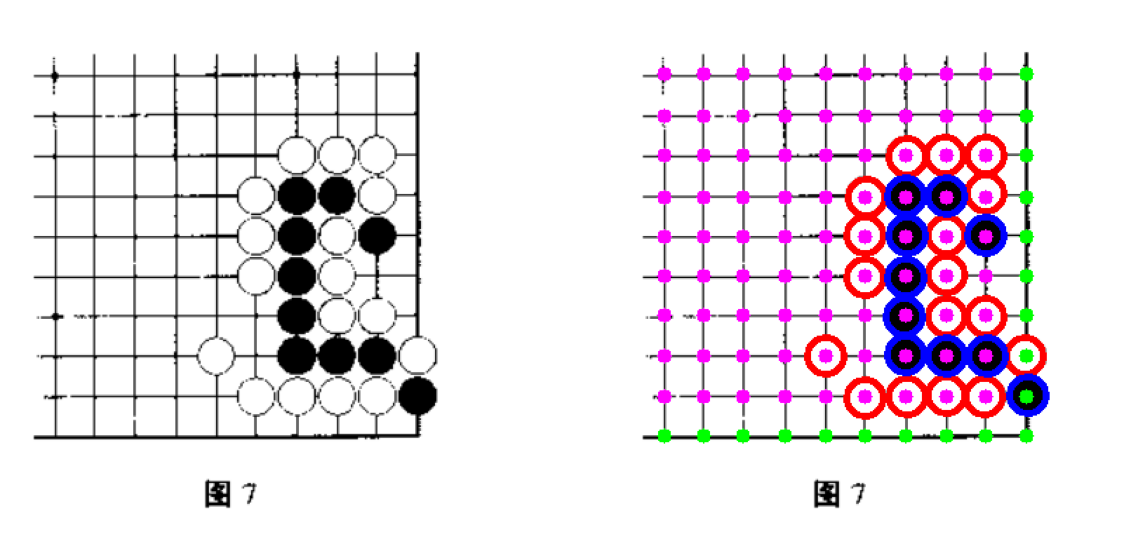

data/images/chinese/6.png


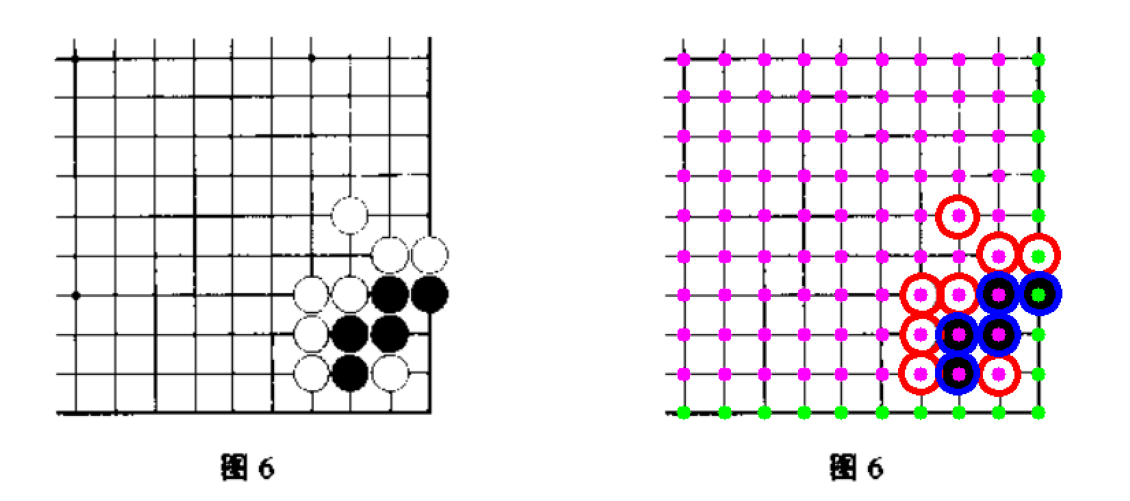

data/images/chinese/2.png


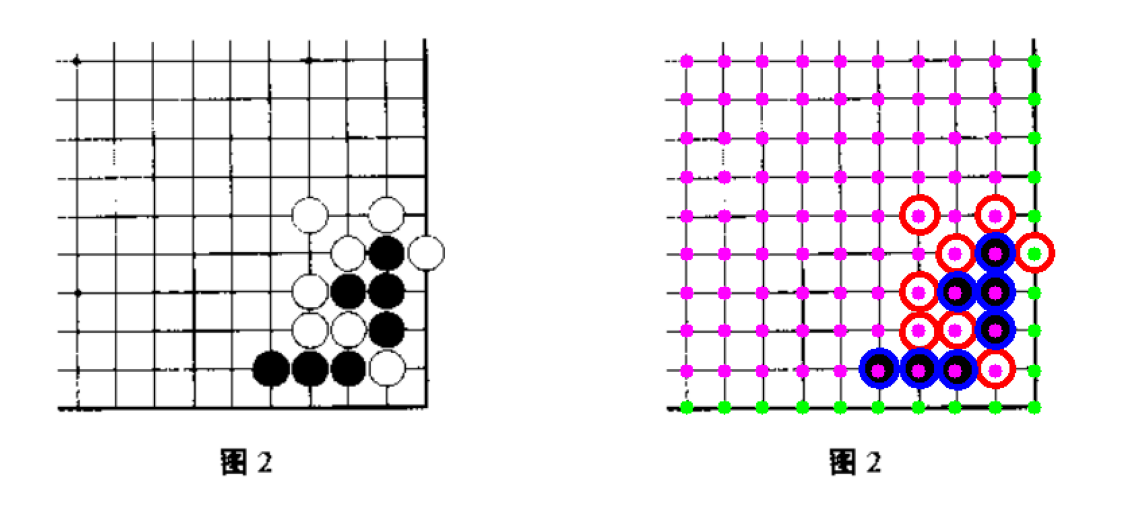

data/images/chinese/3.png


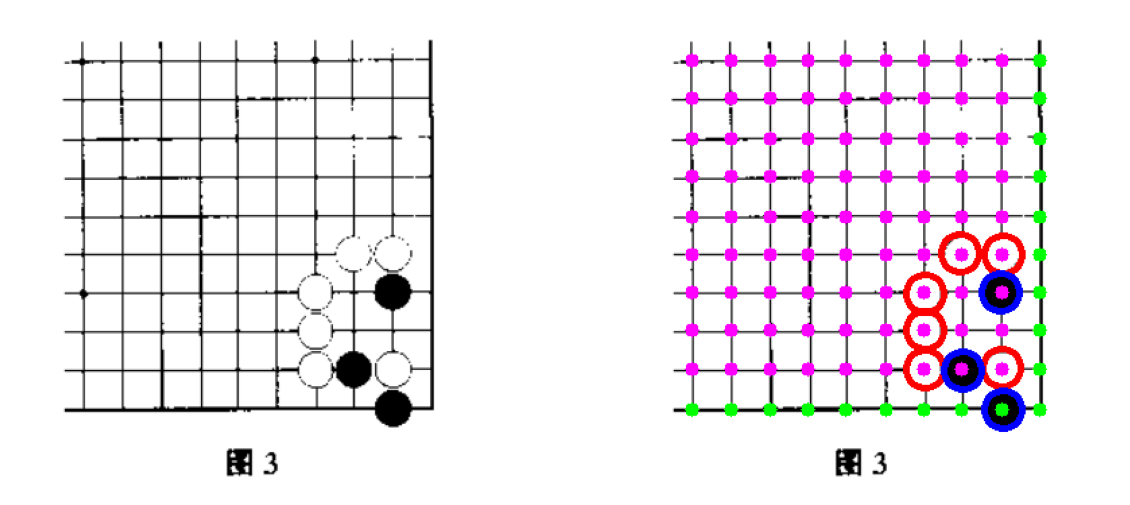

data/images/chinese/1.png


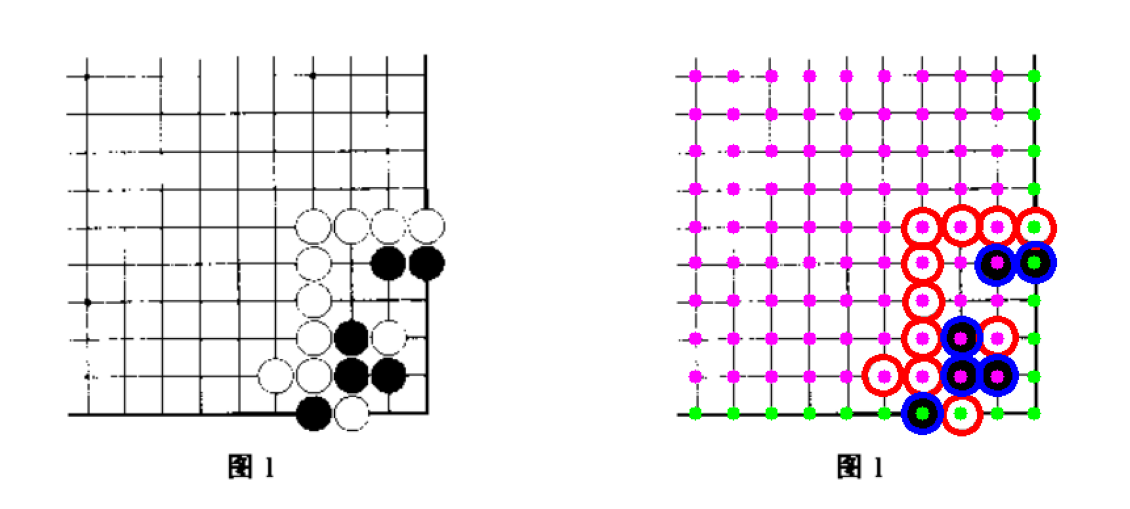

In [10]:
img_files = glob.glob('data/images/chinese/*.png')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize_r(img, r)

data/images/cho_chikun/8.png


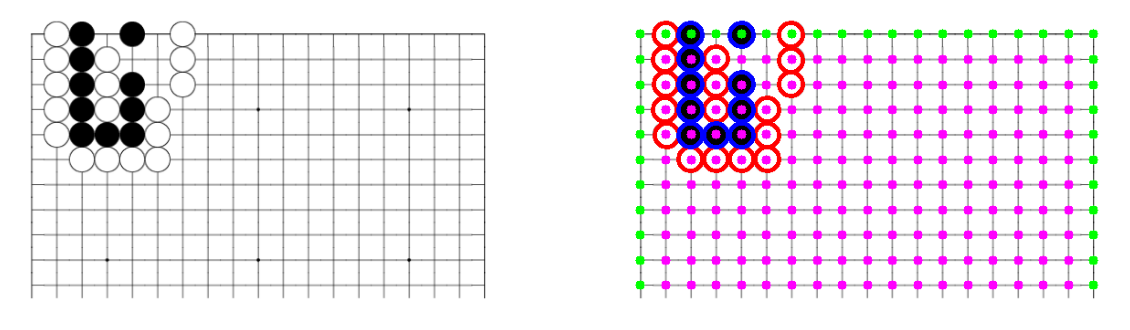

data/images/cho_chikun/4.png


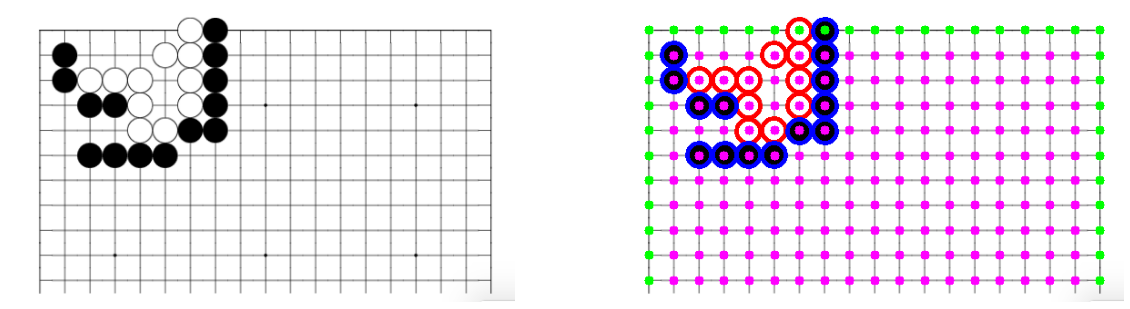

data/images/cho_chikun/5.png


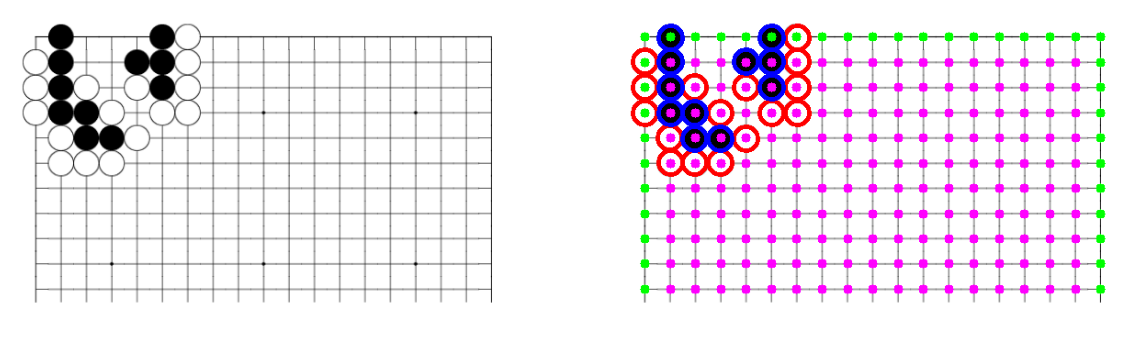

data/images/cho_chikun/7.png


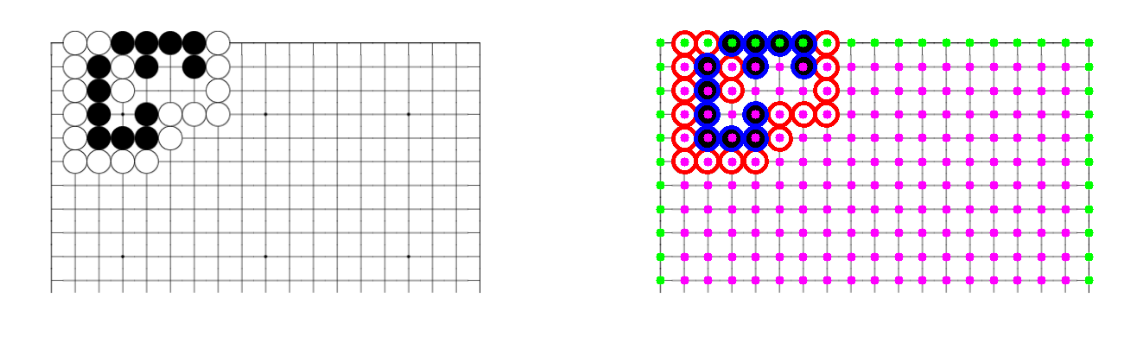

data/images/cho_chikun/6.png


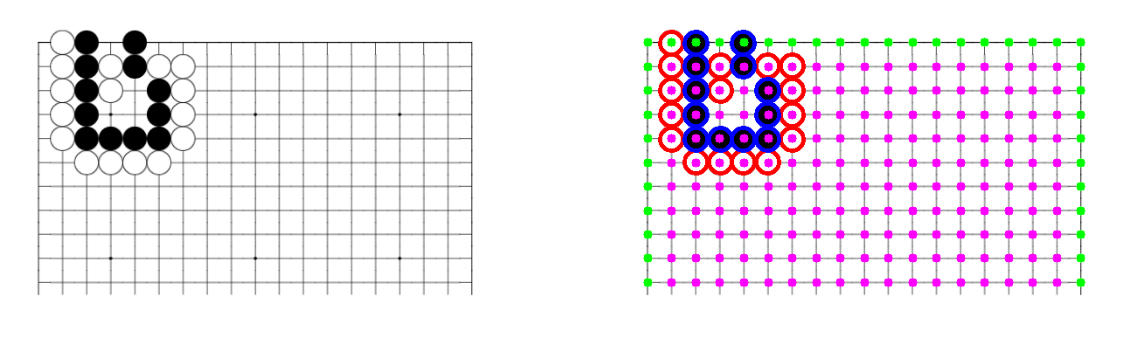

data/images/cho_chikun/2.png


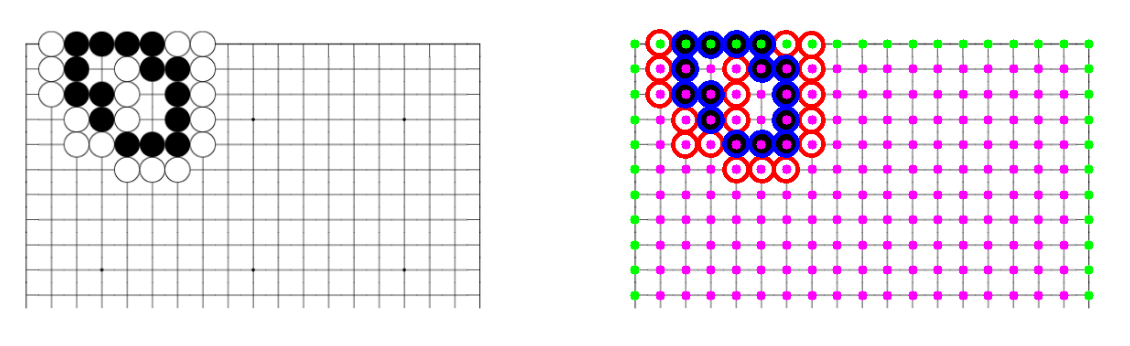

data/images/cho_chikun/3.png


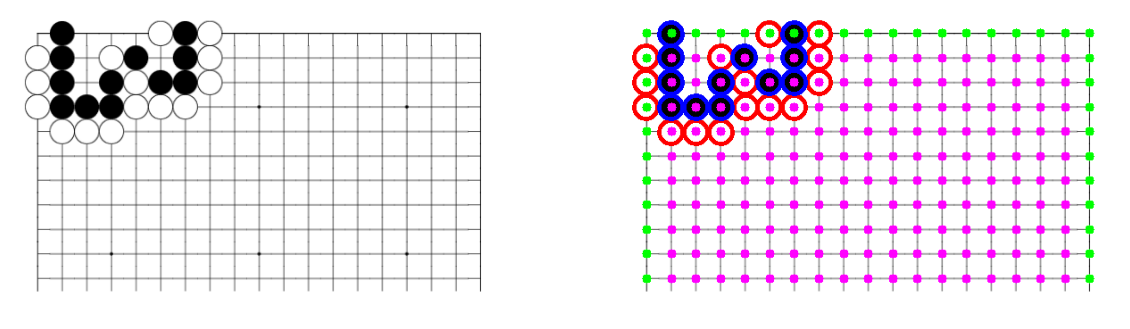

data/images/cho_chikun/1.png


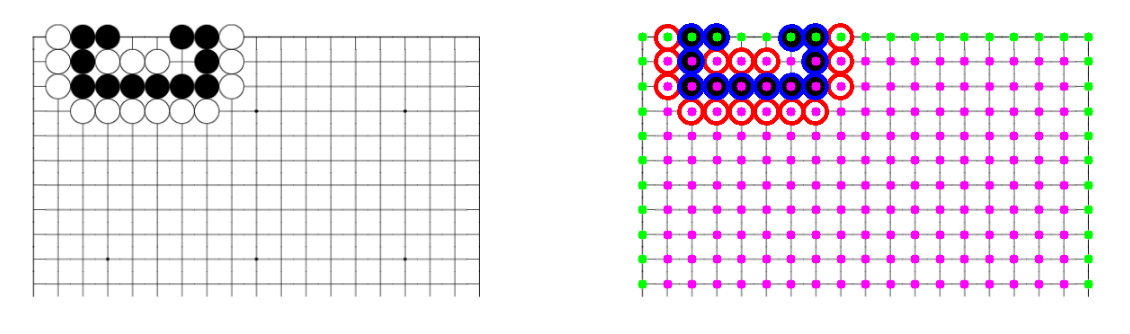

In [11]:
img_files = glob.glob('data/images/cho_chikun/*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize_r(img, r)

data/images/p_8.png


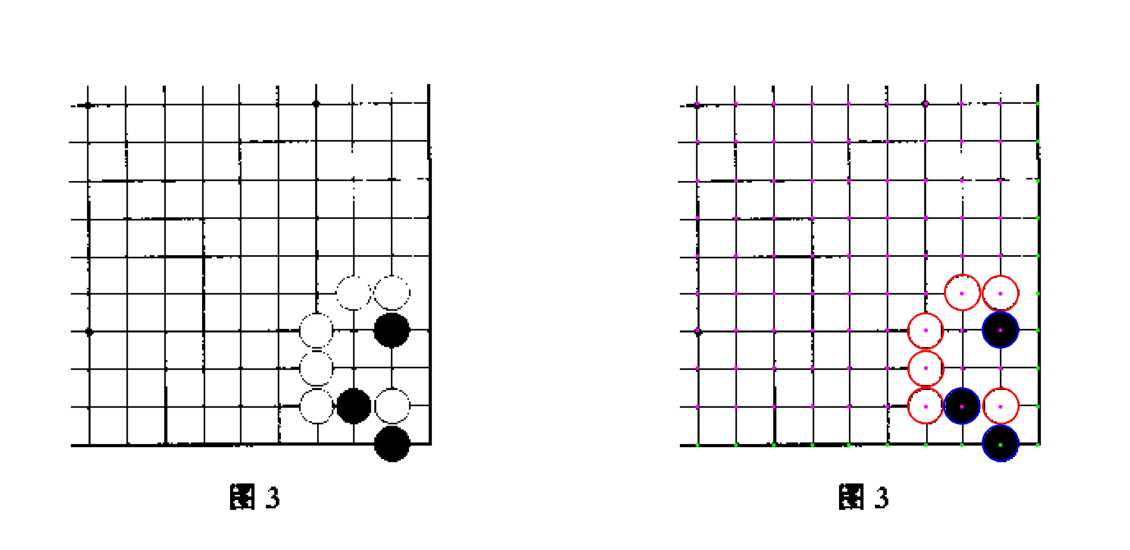

data/images/p_9.png


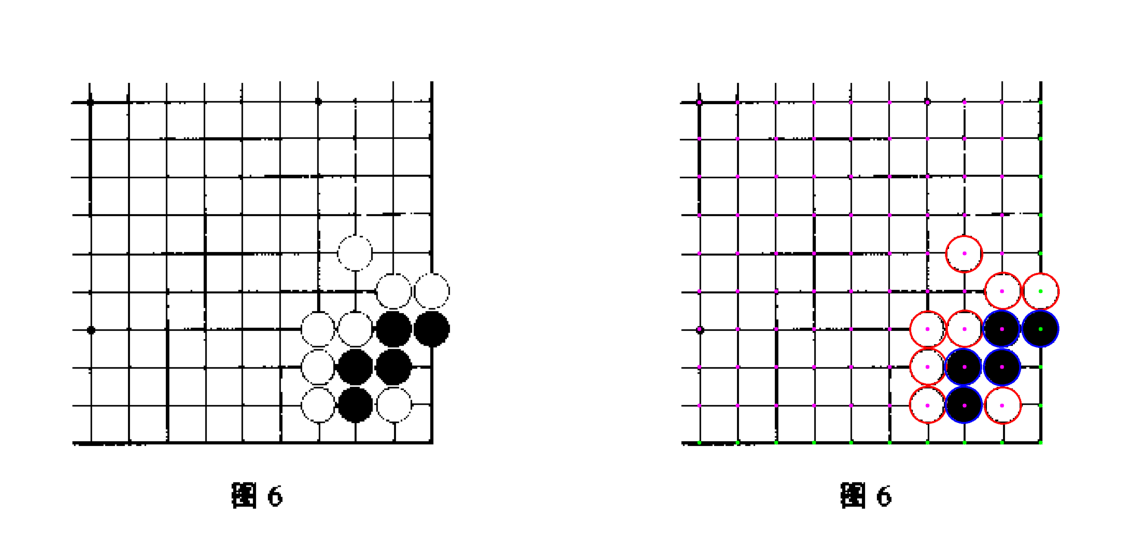

data/images/p_10.png


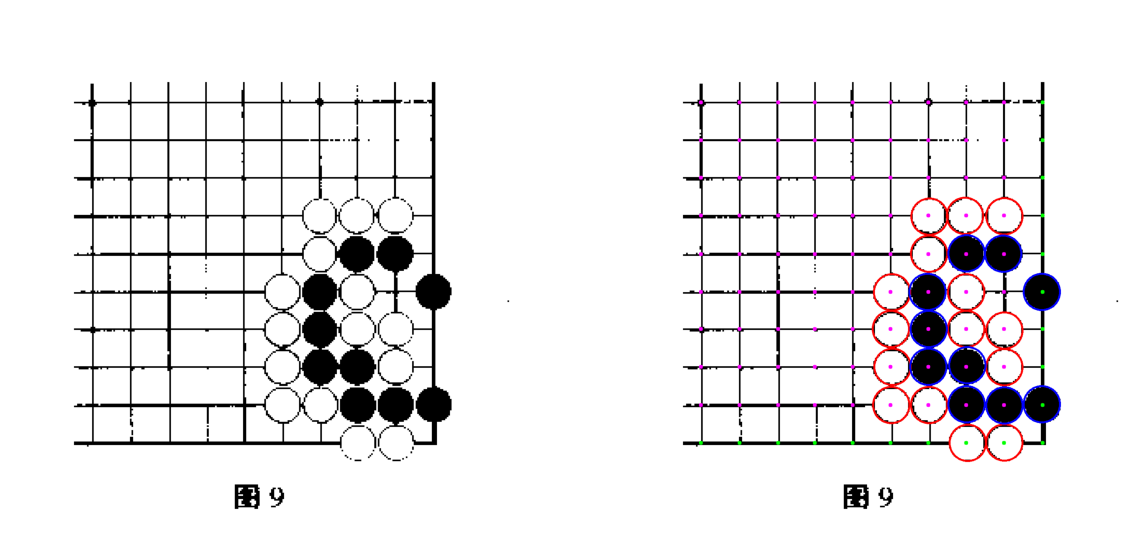

data/images/p_11.png


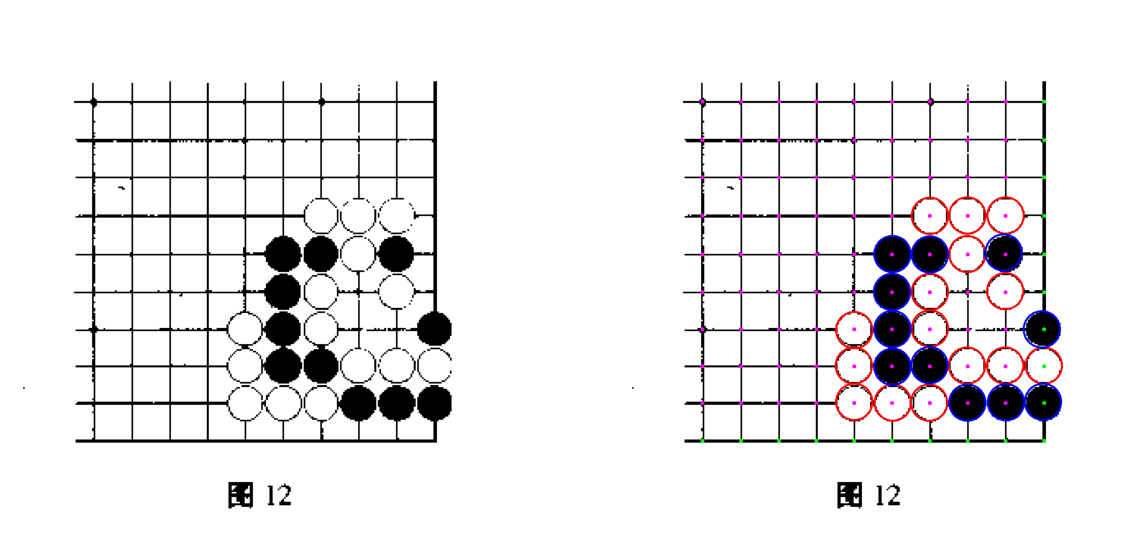

data/images/p_4.png


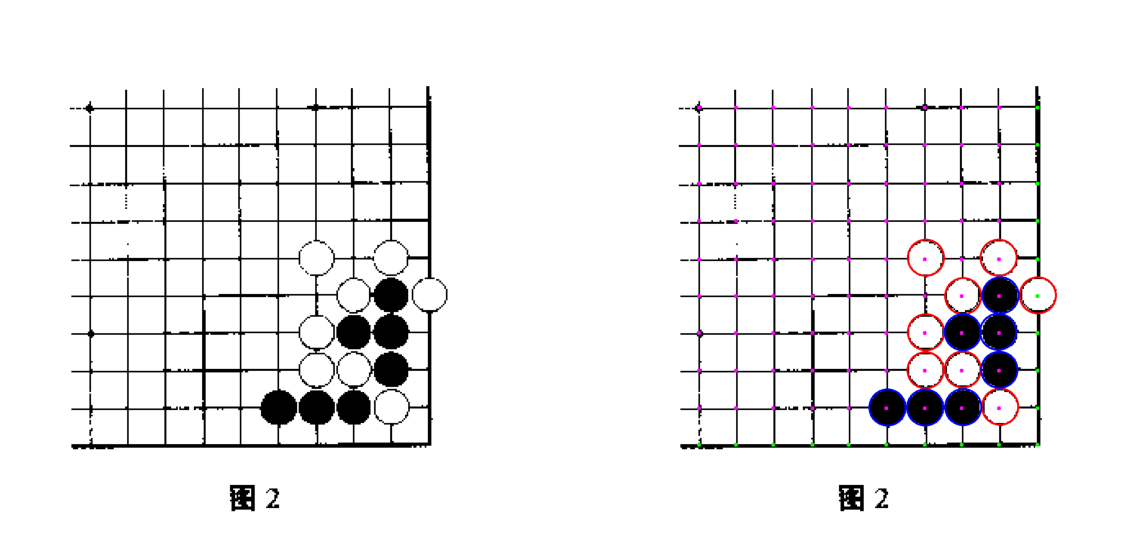

data/images/p_5.png


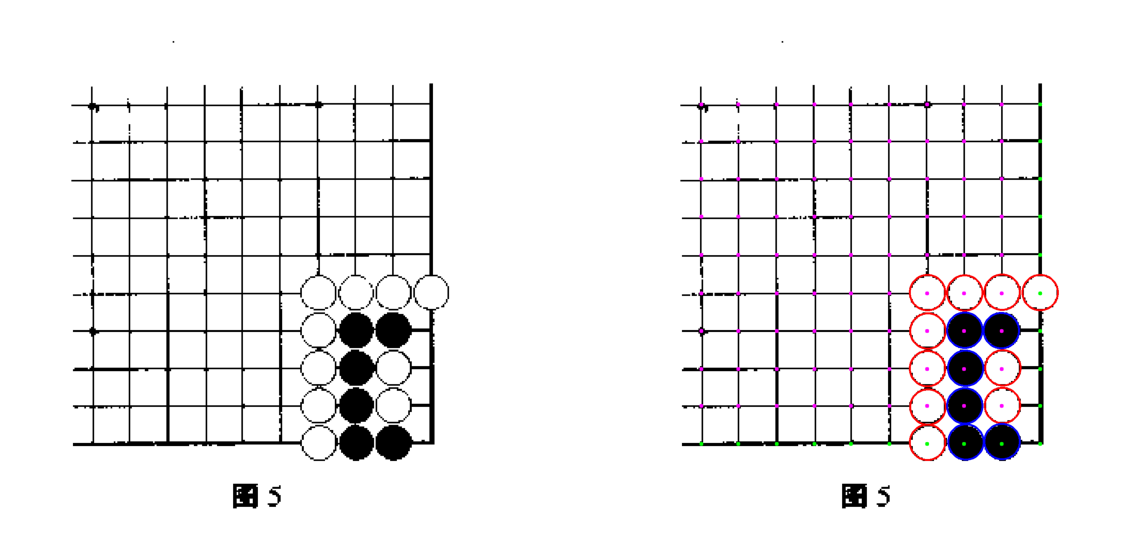

data/images/p_7.png


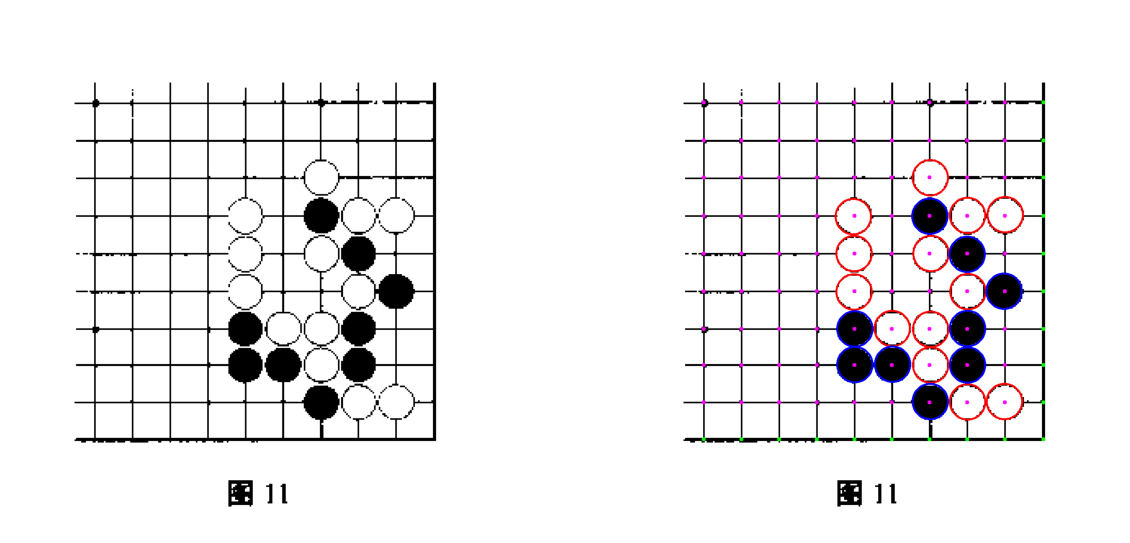

data/images/p_6.png


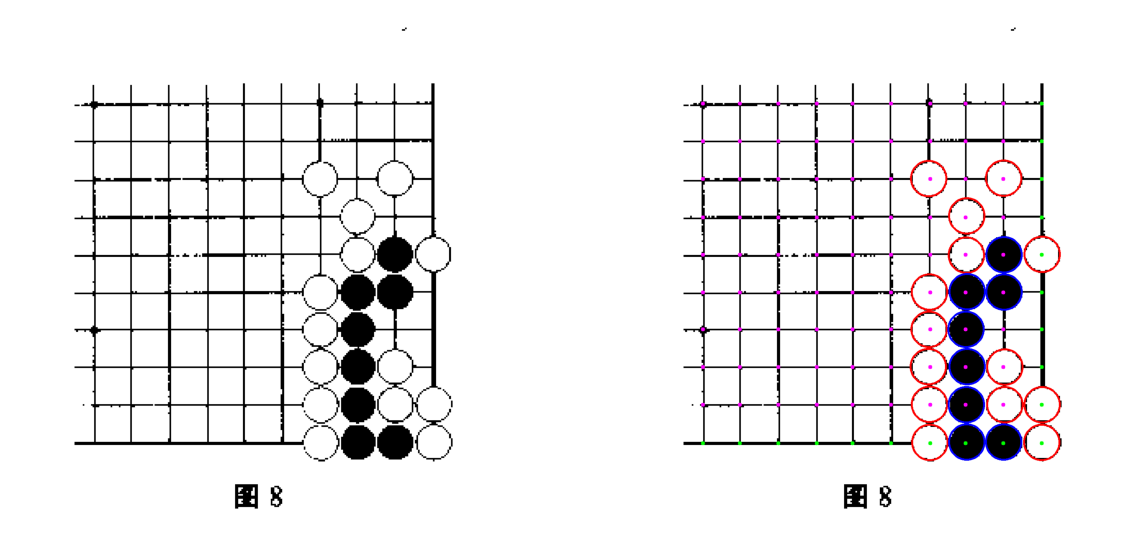

data/images/p_2.png


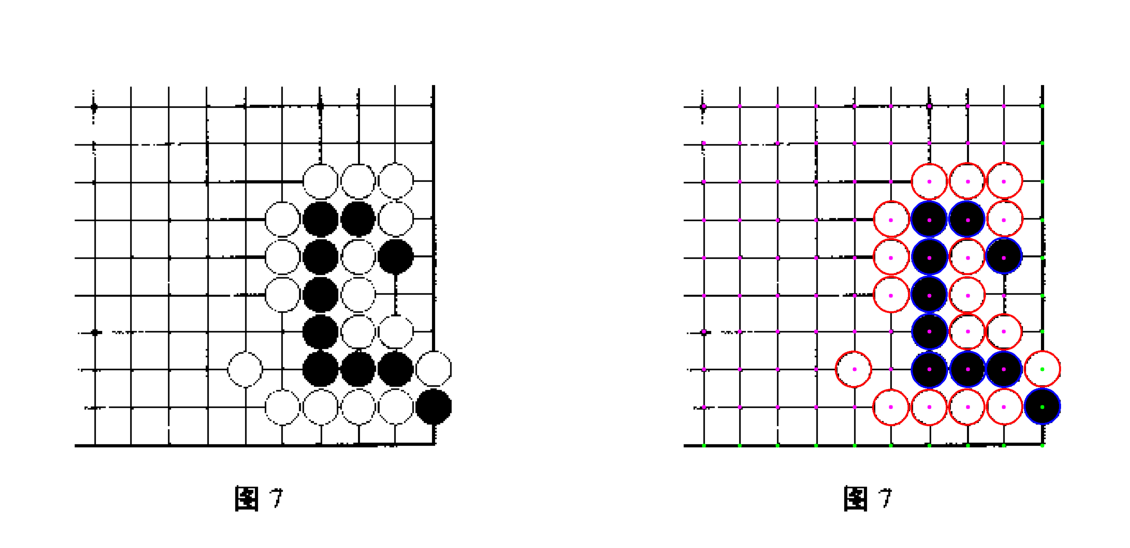

data/images/p_3.png


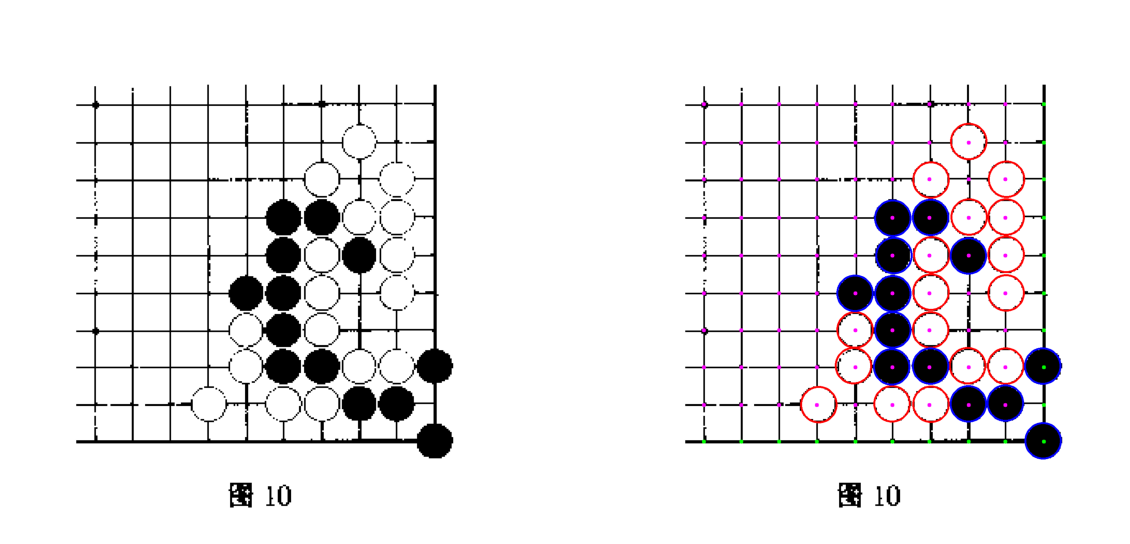

data/images/p_1.png


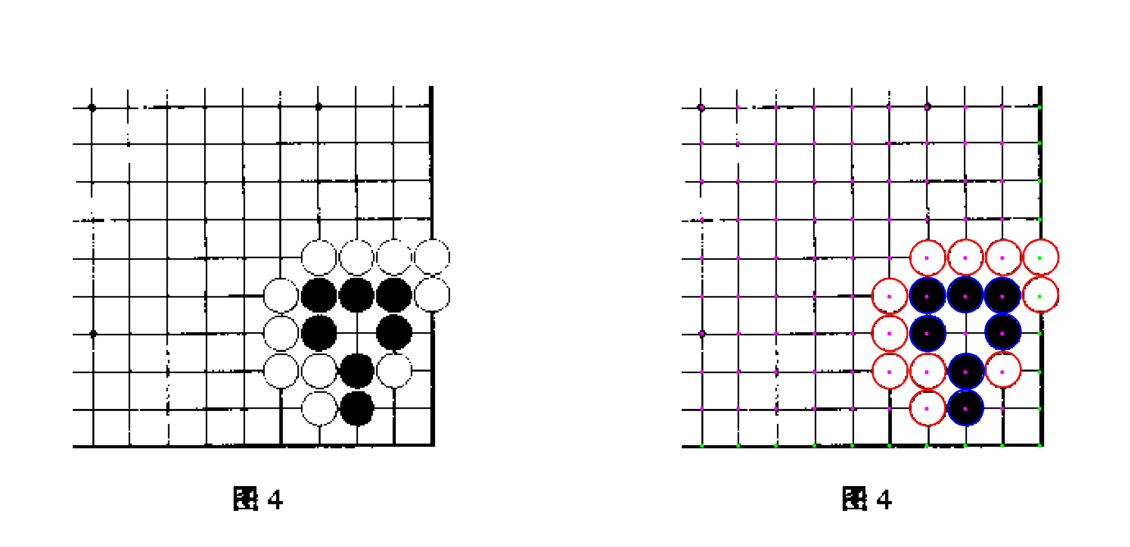

data/images/p_0.png


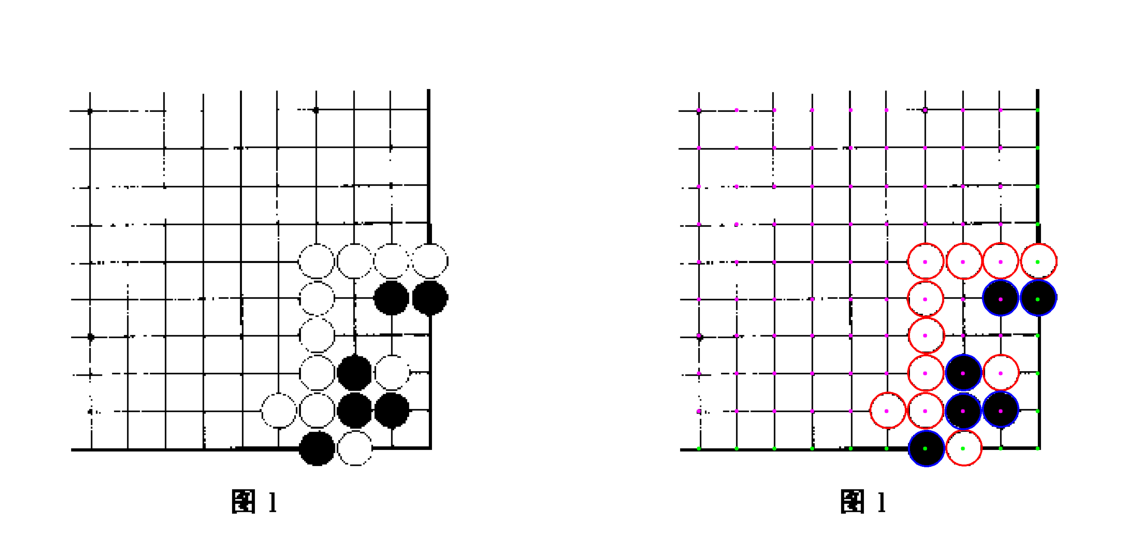

In [12]:
img_files = glob.glob('data/images/p_*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize_r(img, r)

data/images/chinese/signs/s_4.png


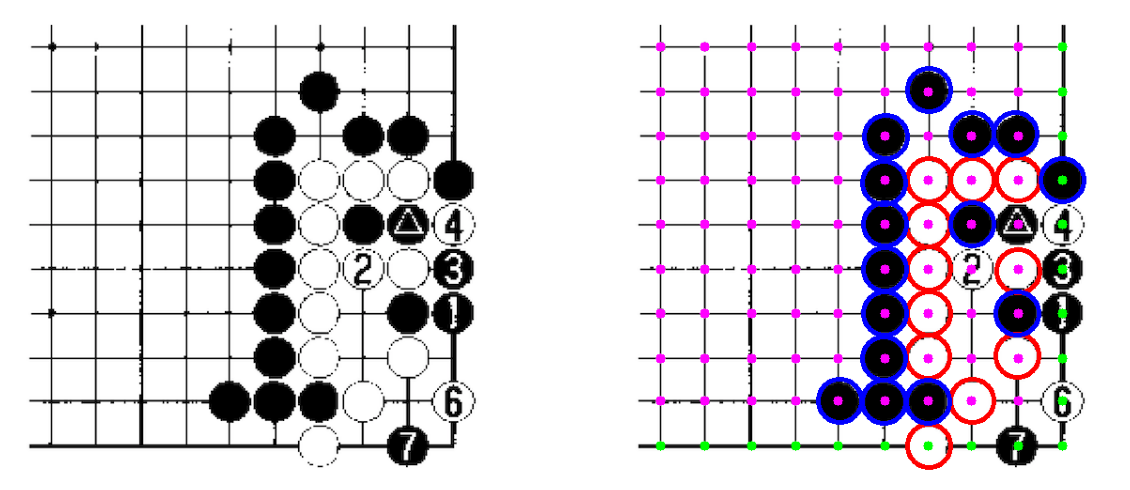

data/images/chinese/signs/s_3.png


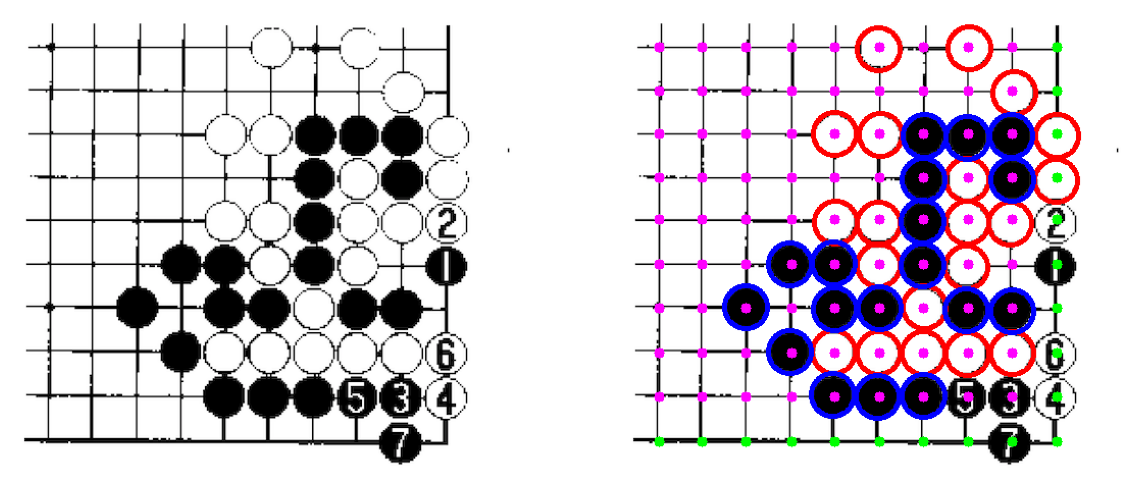

data/images/chinese/signs/s_2.png


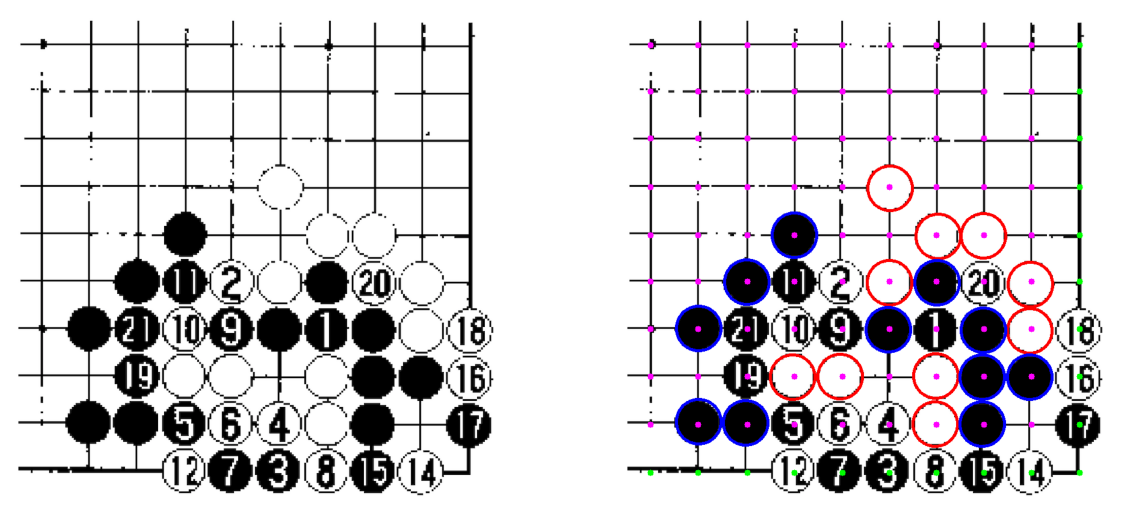

data/images/chinese/signs/s_1.png


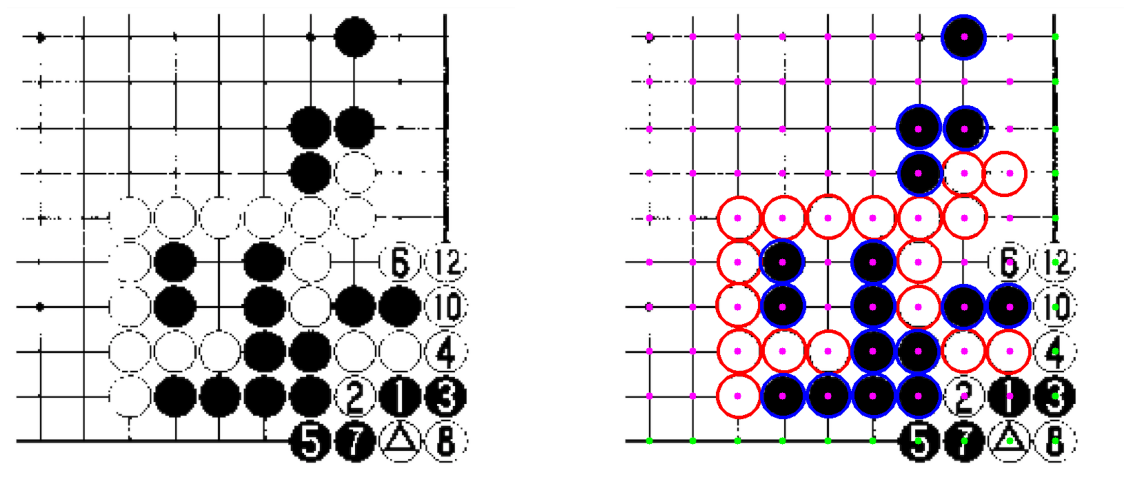

In [13]:
img_files = glob.glob('data/images/chinese/signs/*')
for img_file in img_files:
    print(img_file)
    img = cv2.imread(img_file)
    visualize_r(img, r)